In [157]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import logging
import matplotlib.pyplot as plt

In [158]:
# set the seeds so that we get the same initialization across different trials
seed_random = 1989

In [159]:

log_time = datetime.now().strftime("%d-%m-%Y_%H%M%S")


logging.basicConfig(filename='../Output/train_predictive_models_Masking.log',
                        format='%(asctime)s - %(message)s',
                        level=logging.INFO)
logging.info("Starting the experiemnt...")

antibitics_abx_list = ['NIT', 'SXT', 'CIP', 'LVX']
features_path ='../Data/all_uti_features.csv'
label_path='../Data/all_uti_resist_labels.csv'


In [160]:
# Load in data 
feature_df = pd.read_csv(features_path)
label_df = pd.read_csv(label_path)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
feature_df.drop('example_id', inplace=True, axis=1)
feature_df

,demographics - age,demographics - is_white,demographics - is_veteran,micro - prev resistance LVX 14,micro - prev resistance AMP 14,micro - prev resistance CFZ 14,micro - prev resistance NIT 14,micro - prev resistance GEN 14,micro - prev resistance SXT 14,micro - prev resistance TET 14,...,selected micro - colonization pressure NIT 90 - overall,selected micro - colonization pressure OXA 90 - overall,selected micro - colonization pressure PEN 90 - overall,selected micro - colonization pressure SAM 90 - overall,selected micro - colonization pressure SXT 90 - overall,selected micro - colonization pressure TET 90 - overall,selected micro - colonization pressure TZP 90 - overall,selected micro - colonization pressure VAN 90 - overall,is_train,uncomplicated
0,54,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.24,0.56,0.49,0.38,0.26,0.37,0.06,0.13,0,0
1,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.19,0.78,0.83,0.33,0.20,0.35,0.18,0.13,1,0
2,89,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.21,0.66,0.51,0.50,0.25,0.37,0.05,0.12,1,0
3,49,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.23,0.47,0.50,0.25,0.26,0.35,0.06,0.12,1,0
4,21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.24,0.50,0.49,0.33,0.25,0.37,0.05,0.10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116897,66,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.24,0.49,0.54,0.33,0.25,0.35,0.09,0.10,1,0
116898,74,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.21,0.49,0.50,0.30,0.25,0.34,0.06,0.09,1,0
116899,48,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.21,0.51,0.51,0.28,0.23,0.34,0.05,0.10,1,1
116900,63,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.18,0.52,0.57,0.38,0.27,0.35,0.06,0.12,0,0


In [ ]:
label_df.drop('example_id', inplace=True, axis=1)
label_df

,NIT,SXT,CIP,LVX,is_train,uncomplicated
0,0.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,0.0,1,0
2,0.0,0.0,1.0,1.0,1,0
3,0.0,0.0,0.0,0.0,1,0
4,0.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...
116897,1.0,1.0,1.0,1.0,1,0
116898,NaN,NaN,0.0,0.0,1,0
116899,0.0,0.0,0.0,0.0,1,1
116900,0.0,0.0,0.0,0.0,0,0


In [ ]:
import random
os.environ['PYTHONHASHSEED'] = str(seed_random)
random.seed(seed_random)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
kfold = KFold(n_splits=3, shuffle=True, random_state=1989)

In [ ]:
from tensorflow.keras.layers import *

In [ ]:
from numpy import dstack
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
tf.random.set_seed(seed_random)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

def build_conv1D_model(train_data_reshaped):
    n_timesteps = train_data_reshaped.shape[1] #13
    n_features  = train_data_reshaped.shape[2] #1 
    model = Sequential(name="model_conv1D")
    model.add(Input(shape=(n_timesteps,n_features)))
    #model.add(BatchNormalization(axis=1)
    model.add(Conv1D(filters=16, kernel_size=7, activation='relu', name="Conv1D_1"))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', name="Conv1D_3"))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', name="Dense_1"))
    model.add(Dense(4, activation='sigmoid', name="Dense_2"))

    return model


Extract Train and Test set baselabel

In [ ]:
train_feature_df=(feature_df.loc[feature_df['is_train'] == 1]).loc[feature_df['uncomplicated'] == 1]
test_feature_df=(feature_df.loc[feature_df['is_train'] == 0]).loc[feature_df['uncomplicated'] == 1]
train_label_df=(label_df.loc[label_df['is_train'] == 1]).loc[feature_df['uncomplicated'] == 1]
test_label_df=(label_df.loc[label_df['is_train'] == 0]).loc[feature_df['uncomplicated'] == 1]

In [ ]:
train_feature_df.drop(['uncomplicated','is_train'], inplace=True, axis=1)
test_feature_df.drop(['uncomplicated','is_train'], inplace=True, axis=1)

In [ ]:
train_feature_df.shape

(11865, 788)

Imputing Missing values with 0

In [ ]:
train_feature_df=train_feature_df.fillna(0)
train_label_df[antibitics_abx_list]=train_label_df[antibitics_abx_list].fillna(-1)
test_feature_df=test_feature_df.fillna(0)
test_label_df[antibitics_abx_list]=test_label_df[antibitics_abx_list].fillna(-1)

array([[<AxesSubplot:title={'center':'NIT'}>,
        <AxesSubplot:title={'center':'SXT'}>],
       [<AxesSubplot:title={'center':'CIP'}>,
        <AxesSubplot:title={'center':'LVX'}>]], dtype=object)

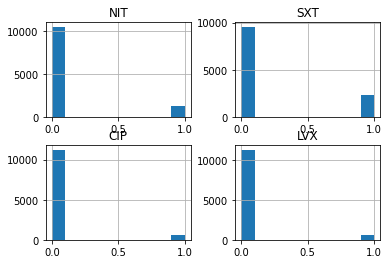

In [ ]:
import matplotlib.pyplot as plt
train_label_df[antibitics_abx_list].hist()

In [ ]:
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metric(history, labels, n,metrics):
  # Use a log scale to show the wide range of values.
  for metric in metrics:
        plt.semilogy(history.epoch, history.history[metric],
                color=colors[n], label='Train '+labels[n])
        plt.semilogy(history.epoch, history.history['val_'+metric],
                color=colors[n], label='Val '+labels[n],
                linestyle="--")
        n=n+1
  plt.xlabel('Epoch')
  plt.ylabel('Metrics')

  plt.legend()
  plt.savefig('output/'+'Plot_Default_'.join(labels)+'.png')

In [ ]:
from tensorflow.keras import backend as K


In [ ]:
mask_value=-1
#model_threshold=0.5

In [ ]:
def masked_accuracy(y_true, y_pred, model_threshold=0.5):
    dtype = K.floatx()
    total = K.sum(K.cast(K.not_equal(y_true, mask_value), dtype))
    #total=K.cast(len(y_true),dtype)
    #correct = K.sum(K.cast(K.equal(y_true, K.round(y_pred)), dtype))
    correct = K.sum(K.cast(K.greater(K.clip(y_pred, 0, 1), model_threshold), dtype))
    #print(correct,total)
    return correct / total

In [ ]:
def masked_loss_function(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    #print(mask)
    return K.binary_crossentropy(y_true * mask, y_pred * mask)

In [ ]:
def masked_f1(y_true, y_pred, model_threshold=0.5):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    dtype = K.floatx()
    def recall_m(y_true, y_pred):
        #TP = K.sum(K.round(K.clip(y_true * y_pred*mask, 0, 1)))
        #Positives = K.sum(K.round(K.clip(y_true*mask, 0, 1)))
        TP=K.sum(K.cast(K.greater(K.clip(y_true * y_pred *mask, 0, 1), model_threshold), dtype) )
        Positives=K.sum(K.cast(K.greater(K.clip(y_true *mask, 0, 1), model_threshold), dtype) )

        recall = TP / (Positives+K.epsilon())    
        return recall 


    def precision_m(y_true, y_pred):
        #TP = K.sum(K.round(K.clip(y_true * y_pred *mask, 0, 1)))
        #Pred_Positives = K.sum(K.round(K.clip(y_pred*mask, 0, 1)))
        TP=K.sum(K.cast(K.greater(K.clip(y_true * y_pred *mask, 0, 1), model_threshold), dtype ))
        Pred_Positives=K.sum(K.cast(K.greater(K.clip(y_pred *mask, 0, 1), model_threshold),dtype))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))
  

In [ ]:
def masked_f1_loss(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(y_true*y_pred*mask, axis=0)
    tn = tf.reduce_sum((1-y_true)*(1-y_pred)*mask, axis=0)
    fp = tf.reduce_sum((1-y_true)*y_pred*mask, axis=0)
    fn = tf.reduce_sum(y_true*(1-y_pred)*mask, axis=0)

    soft_f1= 2 * tp / (2*tp+fn+fp+K.epsilon())

    return 1 - soft_f1

In [ ]:
'''
def masked_f1_double_loss(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(y_true*y_pred*mask, axis=0)
    tn = tf.reduce_sum((1-y_true)*(1-y_pred)*mask, axis=0)
    fp = tf.reduce_sum((1-y_true)*y_pred*mask, axis=0)
    fn = tf.reduce_sum(y_true*(1-y_pred)*mask, axis=0)

    soft_f1_1= 2 * tp / (2*tp+fn+fp+K.epsilon())
    soft_f1_0= 2 * tn / (2*tn+fn+fp+K.epsilon())

    return 1 - 0.5*(soft_f1_1+soft_f1_0)
'''

In [ ]:
def masked_precision(y_true, y_pred, model_threshold=0.5):
    dtype = K.floatx()
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    #TP = K.sum(K.round(K.clip(y_true * y_pred *mask, 0, 1)))
    TP=K.sum(K.cast(K.greater(K.clip(y_true * y_pred *mask, 0, 1), model_threshold), dtype ))
    #Pred_Positives = K.sum(K.round(K.clip(y_pred*mask, 0, 1)))
    Pred_Positives=K.sum(K.cast(K.greater(K.clip(y_pred *mask, 0, 1), model_threshold),dtype))
    precision = TP / (Pred_Positives+K.epsilon())
    return precision 

In [ ]:
def masked_recall(y_true, y_pred, model_threshold=0.5):
    dtype = K.floatx()
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    #TP = K.sum(K.round(K.clip(y_true * y_pred*mask, 0, 1)))
    TP=K.sum(K.cast(K.greater(K.clip(y_true * y_pred *mask, 0, 1), model_threshold), dtype) )
    #Positives = K.sum(K.round(K.clip(y_true*mask, 0, 1)))
    Positives=K.sum(K.cast(K.greater(K.clip(y_true *mask, 0, 1), model_threshold), dtype) )
    
    recall = TP / (Positives+K.epsilon())    
    return recall 

In [ ]:
def masked_specificity(y_true, y_pred, model_threshold=0.5):
    dtype = K.floatx()
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    #TP = K.sum(K.round(K.clip(y_true * y_pred*mask, 0, 1)))
    FP=K.sum(K.cast(K.greater(K.clip((1-y_true) * y_pred *mask, 0, 1), model_threshold),dtype) )
    #Positives = K.sum(K.round(K.clip(y_true*mask, 0, 1)))
    TN=K.sum(K.cast(K.greater(K.clip((1-y_true)*(1-y_pred) *mask, 0, 1), model_threshold),dtype) )
    
    recall = TN / (TN+FP+K.epsilon())    
    return recall 

In [ ]:
def masked_AUC(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    m = tf.keras.metrics.AUC()
    m.update_state(y_true*mask, y_pred*mask)
    return m.result().numpy()

In [ ]:
def masked_SenSpeci_loss(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(y_true*y_pred*mask, axis=0)
    tn = tf.reduce_sum((1-y_true)*(1-y_pred)*mask, axis=0)
    fp = tf.reduce_sum((1-y_true)*y_pred*mask, axis=0)
    fn = tf.reduce_sum(y_true*(1-y_pred)*mask, axis=0)

    soft_sensitivity= tp / (tp+fn+K.epsilon())
    soft_specificity= tn / (tn+fp+K.epsilon())

    return 1 - (soft_sensitivity*soft_specificity)

In [ ]:
def masked_TPTN_loss(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(y_true*y_pred*mask, axis=0)
    tn = tf.reduce_sum((1-y_true)*(1-y_pred)*mask, axis=0)
    fp = tf.reduce_sum((1-y_true)*y_pred*mask, axis=0)
    fn = tf.reduce_sum(y_true*(1-y_pred)*mask, axis=0)


    return 1 - ((tp*tn)/(tp+tn+fp+fn+K.epsilon()))

In [ ]:
'''
def masked_TPPlusTN_loss(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(y_true*y_pred*mask, axis=0)
    tn = tf.reduce_sum((1-y_true)*(1-y_pred)*mask, axis=0)
    fp = tf.reduce_sum((1-y_true)*y_pred*mask, axis=0)
    fn = tf.reduce_sum(y_true*(1-y_pred)*mask, axis=0)


    return 1 - ((tp+tn)/(tp+tn+fp+fn+K.epsilon()))
'''

In [ ]:
#thresholds = [0.2,0.3,0.4,0.5,0.6, 0.7,0.8]

METRICS = [
      masked_accuracy,
      masked_precision,
      masked_recall,
      masked_specificity,
      masked_f1,
      masked_AUC
      #[tf.keras.metrics.BinaryAccuracy(name=f'BiAccuracy+{thr}',threshold=thr) for thr in thresholds],
      #[tf.keras.metrics.Precision(name=f'precision+{thr}',thresholds=thr) for thr in thresholds],
      #[tf.keras.metrics.Recall(name=f'recall_+{thr}',thresholds=thr) for thr in thresholds],
      #tf.keras.metrics.AUC(name='auc'),
      #f1
]

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [ ]:

from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot

In [ ]:
best_result=0.0

In [ ]:
from sklearn.metrics import precision_recall_curve
tf.config.run_functions_eagerly(True)
#tf.enable_eager_execution()

0.02


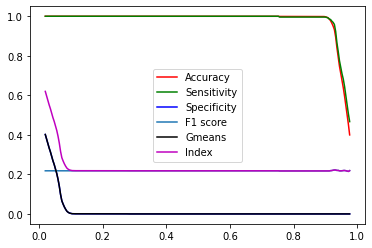

0.02


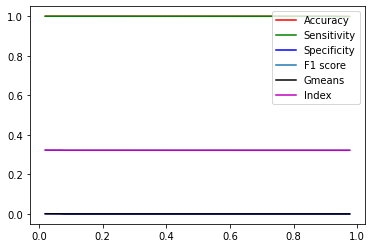

0.216


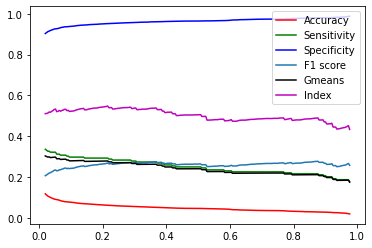

0.396


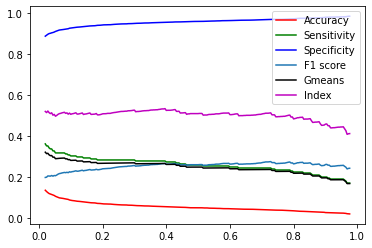

In [182]:
get_threshold(train_label_df, ytrain, y_val_tfidf, ypredict, label_count=4)

In [186]:
def get_threshold( val_label, val_predict, label_count=4):
    partitions=250
    ThreholdList=[]
    for la in range(label_count):
        Threshold=[]
        sensitivity_val=[]
        specificity_val=[]
        accuracy_val=[]
        Gmean=[]
        f1_val=[]
        Index=[]
        for i in range (5, partitions-5):
            sensi=masked_recall(val_label.values[:, la], val_predict[:, la], i/partitions)
            speci=masked_specificity(val_label.values[:, la], val_predict[:, la], i/partitions)
            Threshold.append(i/partitions)
            accuracy_val.append(masked_accuracy(val_label.values[:, la], val_predict[:, la], i/partitions))
            sensitivity_val.append(sensi)
            Gmean.append(speci*sensi)
            specificity_val.append(speci)
            f1=masked_f1(val_label.values[:, la], val_predict[:, la], i/partitions)
            f1_val.append(f1)
            Index.append(f1+speci*sensi)
        ix = argmax(Index)
        print(Threshold[ix])
        ThreholdList.append(Threshold[ix])
        
        plt.plot(Threshold,accuracy_val, c='r', label = "Accuracy")
        plt.plot(Threshold,sensitivity_val, c='g', label = "Sensitivity")
        plt.plot(Threshold,specificity_val, c='b', label = "Specificity")
        plt.plot(Threshold,f1_val, c='C0', label = "F1 score")
        plt.plot(Threshold,Gmean, c='k', label = "Gmeans")
        plt.plot(Threshold,Index, c='m', label = "Index")
        plt.legend()
        plt.show()
    return ThreholdList


In [117]:
'''
def get_threshold(train_label, train_predict, val_label, val_predict, label_count=4):
    
    mask_value=-1
    mask_train = K.cast(K.not_equal(train_label, mask_value), K.floatx())
    mask_train_np=mask_train.numpy()
    Threshold_list_gmean=[0.5,0.5,0.5,0.5]
    Threshold_list_J1=[0.5,0.5,0.5,0.5]
    Threshold_list_F1=[0.5,0.5,0.5,0.5]
    for i in range(label_count):
        fpr, tpr, thres = roc_curve((train_label.values*mask_train_np)[:, i], (train_predict*mask_train_np)[:, i])#test
        print(thres)
        gmeans = sqrt(tpr[1:len(tpr)-2] * (1-fpr[1:len(tpr)-2]))
        ix = argmax(gmeans)
        print(thres[ix])
        Threshold_list_gmean[i]=thres[ix]
        plt.scatter(thres[1:len(tpr)-2],gmeans)
        plt.xlabel("Threshold")
        plt.ylabel("Gmeans")
        plt.show()
        '''
        '''
        J = tpr[1:len(tpr)-1] - fpr[1:len(tpr)-1]
        ix2 = argmax(J)
        print(thres[ix2])
        Threshold_list_J1[i]=thres[ix2]
        plt.scatter(thres[1:len(tpr)-1],J)
        plt.xlabel("Threshold")
        plt.ylabel("J index")
        plt.show()
        '''
        '''
        equal=np.abs(fpr[1:len(tpr)-2]+tpr[1:len(tpr)-2]-1)
        ixeq = np.argmin(equal)
        #Threshold_list_J1[i]=thres[ix2]
        print(thres[ixeq])
        plt.scatter(thres[1:len(tpr)-2],equal)
        plt.xlabel("Threshold")
        plt.ylabel("Equal index")
        plt.show()

        
        precision, recall, thresholds = precision_recall_curve((train_label.values*mask_train_np)[:, i], (train_predict*mask_train_np)[:, i])
        print(thresholds)
        fscore = (2 * precision[1:len(precision)-2] * recall[1:len(precision)-2]) / (precision[1:len(precision)-2] + recall[1:len(precision)-2])
        ix3 = argmax(fscore)
        print(thresholds[ix3])
        Threshold_list_F1[i]=thresholds[ix3]
        plt.scatter(thresholds[1:len(precision)-2],fscore)
        plt.xlabel("Threshold")
        plt.ylabel("fscore index")
        plt.show()
        '''

    '''
    Mean_Threashold=[(x+y+z)/3 for x, y, z in zip(Threshold_list_gmean, Threshold_list_J1, Threshold_list_F1)]
    print(Mean_Threashold)
    sensitivity_Gmean=masked_recall(val_label.values, val_predict, Threshold_list_gmean)
    specificity_Gmean=masked_specificity(val_label.values, val_predict, Threshold_list_gmean)
    F1_Gmean=masked_recall(val_label.values, val_predict, Threshold_list_gmean)

    sensitivity_J1=masked_recall(val_label.values, val_predict, Threshold_list_J1)
    specificity_J1=masked_specificity(val_label.values, val_predict, Threshold_list_J1)
    F1_J1=masked_recall(val_label.values, val_predict, Threshold_list_J1)

    sensitivity_F1=masked_recall(val_label.values, val_predict, Threshold_list_F1)
    specificity_F1=masked_specificity(val_label.values, val_predict, Threshold_list_F1)
    F1_F1=masked_recall(val_label.values, val_predict, Threshold_list_F1)

    sensitivity_mean=masked_recall(val_label.values, val_predict, Mean_Threashold)
    specificity_mean=masked_specificity(val_label.values, val_predict, Mean_Threashold)
    F1_mean=masked_recall(val_label.values, val_predict, Mean_Threashold)

    #Mean_SensitvitySpecificity=(sensitivity_Gmean*specificity_Gmean+sensitivity_J1*specificity_J1+sensitivity_F1*specificity_F1+sensitivity_mean*specificity_mean)/4
    #Mean_Specificity=(specificity_Gmean+specificity_J1+specificity_F1+specificity_mean)/4
    #F1_mean= (F1_Gmean+F1_J1+F1_F1+F1_mean)/4

    Compare_list=[0,0,0,0]
    Compare_list[0]=sensitivity_Gmean*specificity_Gmean+F1_Gmean
    Compare_list[1]=sensitivity_J1*specificity_J1+F1_J1
    Compare_list[2]=sensitivity_F1*specificity_F1+F1_F1
    Compare_list[3]=sensitivity_mean*specificity_mean+F1_mean

    Methodindex = argmax(Compare_list)  
    if (Methodindex ==0):
        return Threshold_list_gmean, Methodindex, Threshold_list_gmean
    elif (Methodindex ==1):
        return Threshold_list_J1, Methodindex, Threshold_list_gmean
    elif (Methodindex ==2):
        return Threshold_list_F1, Methodindex, Threshold_list_gmean
    else:
        return Mean_Threashold, Methodindex, Threshold_list_gmean
    '''

Epoch 1/100
  1/248 [..............................] - ETA: 27s - loss: 0.6764 - masked_accuracy: 0.4375 - masked_precision: 0.1250 - masked_recall: 0.7000 - masked_specificity: 0.5847 - masked_f1: 0.2121 - masked_AUC: 0.7106

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.3513 - masked_accuracy: 0.0053 - masked_precision: 0.0073 - masked_recall: 0.0086 - masked_specificity: 0.9950 - masked_f1: 0.0059 - masked_AUC: 0.6421

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 28s 112ms/step - loss: 0.3513 - masked_accuracy: 0.0053 - masked_precision: 0.0072 - masked_recall: 0.0086 - masked_specificity: 0.9950 - masked_f1: 0.0059 - masked_AUC: 0.6429 - val_loss: 0.3364 - val_masked_accuracy: 0.0000e+00 - val_masked_precision: 0.0000e+00 - val_masked_recall: 0.0000e+00 - val_masked_specificity: 1.0000 - val_masked_f1: 0.0000e+00 - val_masked_AUC: 0.6866
Epoch 2/100
248/248 [==============================] - 28s 114ms/step - loss: 0.3096 - masked_accuracy: 4.0953e-04 - masked_precision: 0.0262 - masked_recall: 0.0021 - masked_specificity: 0.9998 - masked_f1: 0.0038 - masked_AUC: 0.7072 - val_loss: 0.3228 - val_masked_accuracy: 2.5202e-04 - val_masked_precision: 0.0161 - val_masked_recall: 0.0018 - val_masked_specificity: 0.9999 - val_masked_f1: 0.0032 - val_masked_AUC: 0.7035asked_recall: 0.0022 - masked_specificity: 0.9998 - masked_f1: 0.0040 
Epoch 3/100
248/248 [==============================] - 28s 112ms/step - lo

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.32745254039764404, 0.010584677569568157, 0.30589476227760315, 0.054030247032642365, 0.995123028755188, 0.08814040571451187, 0.6927700638771057]
0.104


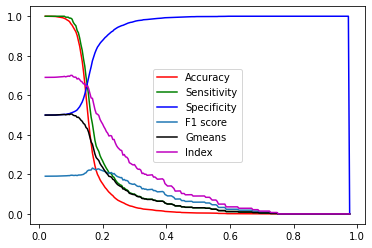

0.124


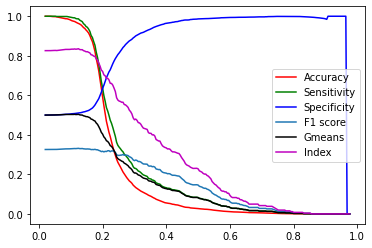

0.028


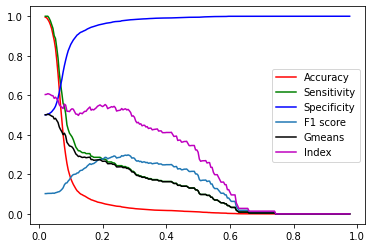

0.02


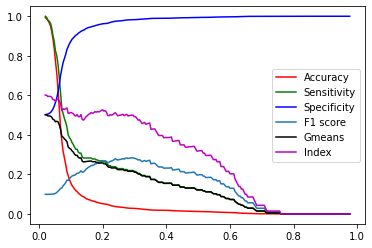

Epoch 1/100
  1/248 [..............................] - ETA: 24s - loss: 0.6878 - masked_accuracy: 0.4062 - masked_precision: 0.0385 - masked_recall: 0.2857 - masked_specificity: 0.5868 - masked_f1: 0.0678 - masked_AUC: 0.4144

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.3611 - masked_accuracy: 0.0049 - masked_precision: 9.6628e-04 - masked_recall: 0.0030 - masked_specificity: 0.9949 - masked_f1: 0.0013 - masked_AUC: 0.6119

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 27s 111ms/step - loss: 0.3612 - masked_accuracy: 0.0049 - masked_precision: 9.6238e-04 - masked_recall: 0.0030 - masked_specificity: 0.9949 - masked_f1: 0.0013 - masked_AUC: 0.6125 - val_loss: 0.3437 - val_masked_accuracy: 0.0000e+00 - val_masked_precision: 0.0000e+00 - val_masked_recall: 0.0000e+00 - val_masked_specificity: 1.0000 - val_masked_f1: 0.0000e+00 - val_masked_AUC: 0.6772
Epoch 2/100
248/248 [==============================] - 27s 111ms/step - loss: 0.3121 - masked_accuracy: 1.2601e-04 - masked_precision: 0.0161 - masked_recall: 0.0010 - masked_specificity: 1.0000 - masked_f1: 0.0020 - masked_AUC: 0.6947 - val_loss: 0.3217 - val_masked_accuracy: 6.3004e-04 - val_masked_precision: 0.0403 - val_masked_recall: 0.0036 - val_masked_specificity: 0.9996 - val_masked_f1: 0.0066 - val_masked_AUC: 0.7149
Epoch 3/100
248/248 [==============================] - 27s 110ms/step - loss: 0.3056 - masked_accuracy: 8.1905e-04 - masked_precision: 0.050

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.3312053382396698, 0.013104838319122791, 0.31599459052085876, 0.05614127591252327, 0.9924325346946716, 0.09157198667526245, 0.6894294619560242]
0.024


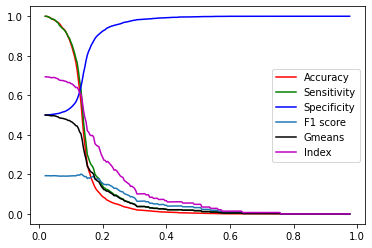

0.124


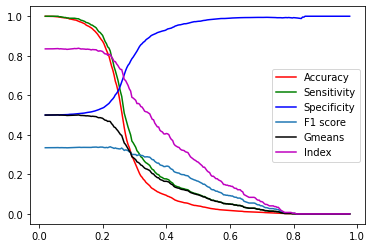

0.22


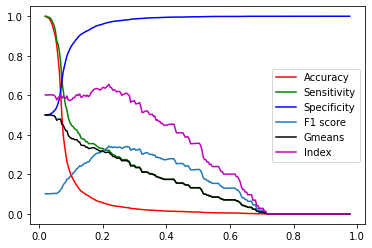

0.204


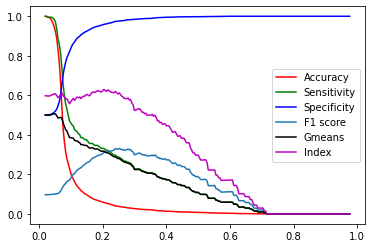

Epoch 1/100
  1/248 [..............................] - ETA: 28s - loss: 0.6972 - masked_accuracy: 0.5156 - masked_precision: 0.0758 - masked_recall: 0.7143 - masked_specificity: 0.4959 - masked_f1: 0.1370 - masked_AUC: 0.5325

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.3533 - masked_accuracy: 0.0061 - masked_precision: 0.0026 - masked_recall: 0.0075 - masked_specificity: 0.9941 - masked_f1: 0.0033 - masked_AUC: 0.6363 - ETA: 18s - loss: 0.4509 - masked_accuracy: 0.0273 - masked_precision: 0.0116 - masked_recall: 0.0339 - masked_specificity: 0.9734 - masked_f1: 0.0147 - masked_AUC:  - ETA: 17s - loss: 0.4414 - masked_accuracy: 0.0246 - masked_precision: 0.0105 - masked_recall: 0.0305 - masked_specificity: 0.9760 - masked_f1: 0.0133 - masked_AU - ETA: 16s - loss: 0.4306 - masked_accuracy: 0.0214 - masked_precision: 0.0091 - masked_recall: 0.0266 - masked_specif - ETA: 11s - loss: 0.3866 - masked_accuracy: 0.0121 - masked_precision: 0.0051 - masked_recall: 0.0150 - masked_specificity: 0.9882 - masked_f1: - ETA: 9s - loss: 0.3800 - masked_accuracy: 0.0102 - masked_precision: 0.0043 - masked_re - ETA: 5s - loss: 0.3664 - masked_accuracy: 0.0080 - masked_precision: 0.0034 - masked_recall: 0.0099 

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 27s 110ms/step - loss: 0.3531 - masked_accuracy: 0.0060 - masked_precision: 0.0026 - masked_recall: 0.0075 - masked_specificity: 0.9941 - masked_f1: 0.0033 - masked_AUC: 0.6338 - val_loss: 0.3386 - val_masked_accuracy: 0.0000e+00 - val_masked_precision: 0.0000e+00 - val_masked_recall: 0.0000e+00 - val_masked_specificity: 1.0000 - val_masked_f1: 0.0000e+00 - val_masked_AUC: 0.6866
Epoch 2/100
248/248 [==============================] - 27s 109ms/step - loss: 0.3080 - masked_accuracy: 9.4506e-05 - masked_precision: 0.0121 - masked_recall: 7.7723e-04 - masked_specificity: 1.0000 - masked_f1: 0.0015 - masked_AUC: 0.6990 - val_loss: 0.3294 - val_masked_accuracy: 3.7802e-04 - val_masked_precision: 0.0242 - val_masked_recall: 0.0022 - val_masked_specificity: 0.9999 - val_masked_f1: 0.0039 - val_masked_AUC: 0.7153
Epoch 3/100
248/248 [==============================] - 27s 109ms/step - loss: 0.3024 - masked_accuracy: 0.0011 - masked_precision: 0.0524 - 

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.33230942487716675, 0.007623488083481789, 0.27889785170555115, 0.03989901766180992, 0.9965572953224182, 0.06655518710613251, 0.6909055113792419]
0.104


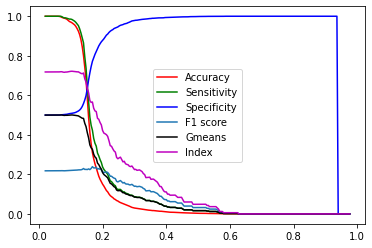

0.18


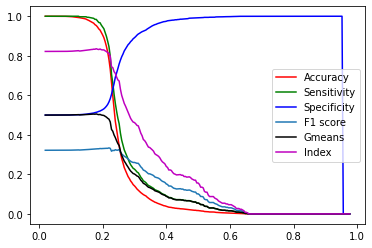

0.072


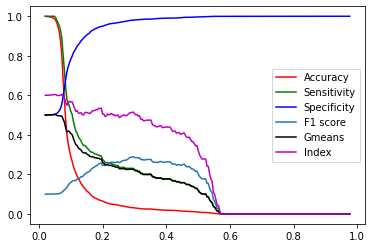

0.052


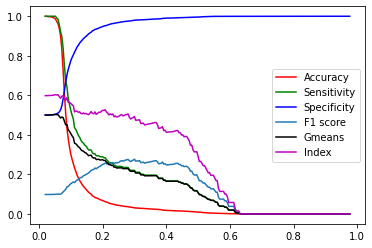

0.010437667990724245 0.002240165018273478 0.3002624015013377 0.01565960032734548 0.050023513535658516 0.007210786977744097 0.9947042862574259 0.001709760513176449 0.6910350124041239 0.0013668658030612808 0.08208919316530228 0.011073179162802607
0.6241436 0.15880778 0.14519995 0.019385636 0.80674076 0.10897861 0.63109404 0.06664231 0.24370481 0.021638934


In [208]:
accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
specificity=[]
auclist=[]
flist=[]


accuracyresultlist_T=[]
precisionresultlist_T=[]
recallresultlist_T=[]
specificity_T=[]
flist_T=[]


for train_index, validate_index in kfold.split(train_feature_df, train_label_df[antibitics_abx_list]):
    X=train_feature_df
    Y=train_label_df[antibitics_abx_list]
    x_train_tfidf = X.iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_val_tfidf = X.iloc[validate_index]
    y_val_tfidf = Y.iloc[validate_index]
    x_train_tfidf=x_train_tfidf.reset_index(drop=True)
    y_train_tfidf=y_train_tfidf.reset_index(drop=True)
    x_val_tfidf=x_val_tfidf.reset_index(drop=True)
    y_val_tfidf=y_val_tfidf.reset_index(drop=True)
    sample_size = x_train_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_train_tfidf.values.shape[1] # number of features in train set
    input_dimension = 1               # each feature is represented by 1 number
    train_data_reshaped = x_train_tfidf.values.reshape(sample_size,time_steps,input_dimension)
    #x_test_tfidf = (x_test_tfidf.values)
    #y_test_tfidf=(y_test_tfidf.values)
    sample_size = x_val_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_val_tfidf.values.shape[1] # number of features in train set

    x_val_reshaped = x_val_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    x_test_tfidf=test_feature_df.reset_index(drop=True)
    y_test_tfidf =test_label_df[antibitics_abx_list].reset_index(drop=True)
    sample_size = x_test_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_test_tfidf.values.shape[1] # number of features in train set
    test_data_reshaped =x_test_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    #model = Tran_Model(train_data_reshaped)
    model=build_conv1D_model(train_data_reshaped)
    model.compile(loss=masked_loss_function,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=METRICS)
    
    history = model.fit(train_data_reshaped, y_train_tfidf, epochs=EPOCHS,validation_data=(x_val_reshaped, y_val_tfidf), callbacks=[es], verbose=1)
    results = model.evaluate(test_data_reshaped, y_test_tfidf, verbose=0)
    print(results)
    if (results[6] > best_result):
        model.save('output/Best_Model_Default_Masking')
        best_result=results[6]
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    specificity.append(results[4])
    auclist.append(results[6])
    flist.append(results[5])
    
    ypredict = model.predict(x_val_reshaped)
    ytrain = model.predict(train_data_reshaped)
    Threshold_list=get_threshold(y_val_tfidf, ypredict, label_count=4)
    
    ypredictTest = model.predict(test_data_reshaped)
    accuracyresultlist_T.append(masked_accuracy(y_test_tfidf,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    precisionresultlist_T.append(masked_precision(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    recallresultlist_T.append(masked_recall(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    specificity_T.append(masked_specificity(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    flist_T.append(masked_f1(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())

    


print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))

In [209]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))

0.010437667990724245 0.002240165018273478 0.3002624015013377 0.01565960032734548 0.050023513535658516 0.007210786977744097 0.9947042862574259 0.001709760513176449 0.6910350124041239 0.0013668658030612808 0.08208919316530228 0.011073179162802607
0.6241436 0.15880778 0.14519995 0.019385636 0.80674076 0.10897861 0.63109404 0.06664231 0.24370481 0.021638934


In [189]:
logging.info('REsults {np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist)}')

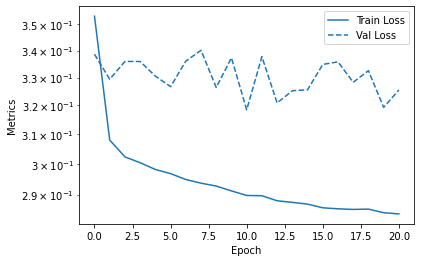

In [210]:
plot_metric(history, ['Loss',], 0,['loss',])

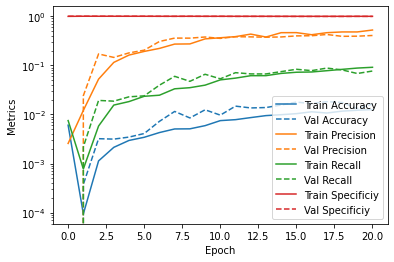

In [211]:
plot_metric(history, ['Accuracy', 'Precision','Recall', 'Specificiy'], 0,['masked_accuracy', 'masked_precision','masked_recall', 'masked_specificity'])

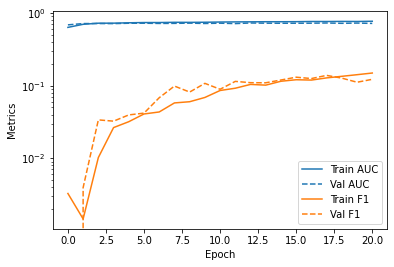

In [212]:
plot_metric(history, ['AUC', 'F1'], 0,['masked_AUC', 'masked_f1'])

F1 Loss 

Epoch 1/100
  1/248 [..............................] - ETA: 28s - loss: 0.8732 - masked_accuracy: 0.4844 - masked_precision: 0.1452 - masked_recall: 0.9000 - masked_specificity: 0.5508 - masked_f1: 0.2500 - masked_AUC: 0.7280

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.8213 - masked_accuracy: 0.7837 - masked_precision: 0.1229 - masked_recall: 0.9207 - masked_specificity: 0.2317 - masked_f1: 0.2144 - masked_AUC: 0.6935

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 26s 106ms/step - loss: 0.8212 - masked_accuracy: 0.7832 - masked_precision: 0.1234 - masked_recall: 0.9210 - masked_specificity: 0.2323 - masked_f1: 0.2151 - masked_AUC: 0.6942 - val_loss: 0.8198 - val_masked_accuracy: 0.6217 - val_masked_precision: 0.1394 - val_masked_recall: 0.8657 - val_masked_specificity: 0.4046 - val_masked_f1: 0.2370 - val_masked_AUC: 0.7038
Epoch 2/100
248/248 [==============================] - 27s 107ms/step - loss: 0.7898 - masked_accuracy: 0.5508 - masked_precision: 0.1556 - masked_recall: 0.8416 - masked_specificity: 0.4811 - masked_f1: 0.2592 - masked_AUC: 0.7043 - val_loss: 0.8037 - val_masked_accuracy: 0.5340 - val_masked_precision: 0.1522 - val_masked_recall: 0.8169 - val_masked_specificity: 0.4964 - val_masked_f1: 0.2529 - val_masked_AUC: 0.7026
Epoch 3/100
248/248 [==============================] - 27s 108ms/step - loss: 0.7814 - masked_accuracy: 0.5368 - masked_precision: 0.1585 - masked_recall: 0.8333 - mask

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.7936927080154419, 0.5522933602333069, 0.15268848836421967, 0.7932447791099548, 0.47533920407295227, 0.25293225049972534, 0.673169732093811]
0.02


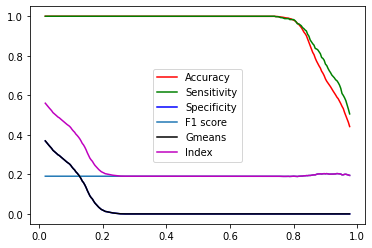

0.02


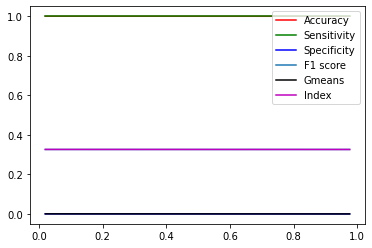

0.236


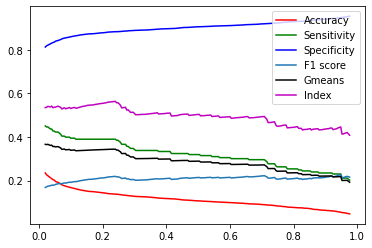

0.02


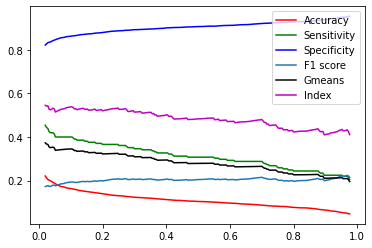

Epoch 1/100
  1/248 [..............................] - ETA: 23s - loss: 0.9033 - masked_accuracy: 0.7031 - masked_precision: 0.0444 - masked_recall: 0.5714 - masked_specificity: 0.2893 - masked_f1: 0.0825 - masked_AUC: 0.4309

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.8223 - masked_accuracy: 0.9319 - masked_precision: 0.1083 - masked_recall: 0.9741 - masked_specificity: 0.0729 - masked_f1: 0.1929 - masked_AUC: 0.6914

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 27s 108ms/step - loss: 0.8222 - masked_accuracy: 0.9315 - masked_precision: 0.1089 - masked_recall: 0.9735 - masked_specificity: 0.0733 - masked_f1: 0.1937 - masked_AUC: 0.6911 - val_loss: 0.8148 - val_masked_accuracy: 0.7645 - val_masked_precision: 0.1227 - val_masked_recall: 0.9165 - val_masked_specificity: 0.2522 - val_masked_f1: 0.2143 - val_masked_AUC: 0.7081
Epoch 2/100
248/248 [==============================] - 27s 108ms/step - loss: 0.8014 - masked_accuracy: 0.6482 - masked_precision: 0.1387 - masked_recall: 0.8747 - masked_specificity: 0.3763 - masked_f1: 0.2365 - masked_AUC: 0.6919 - val_loss: 0.7915 - val_masked_accuracy: 0.5470 - val_masked_precision: 0.1562 - val_masked_recall: 0.8416 - val_masked_specificity: 0.4856 - val_masked_f1: 0.2602 - val_masked_AUC: 0.6984
Epoch 3/100
248/248 [==============================] - 27s 109ms/step - loss: 0.7871 - masked_accuracy: 0.5422 - masked_precision: 0.1554 - masked_recall: 0.8374 - mask

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.7928453683853149, 0.5309979915618896, 0.15564195811748505, 0.7795290350914001, 0.49739670753479004, 0.2562192976474762, 0.6410070061683655]
0.02


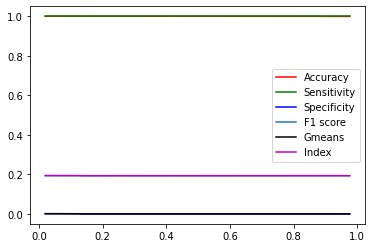

0.02


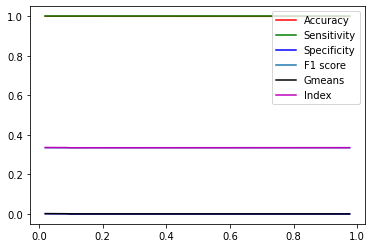

0.268


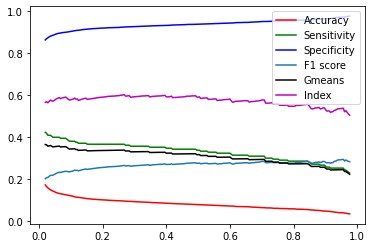

0.34


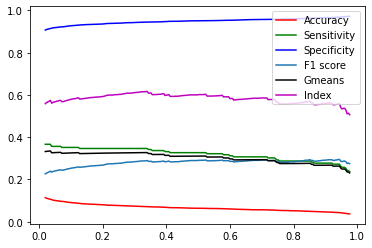

Epoch 1/100
  1/248 [..............................] - ETA: 24s - loss: 0.9032 - masked_accuracy: 0.4297 - masked_precision: 0.0909 - masked_recall: 0.7143 - masked_specificity: 0.5868 - masked_f1: 0.1613 - masked_AUC: 0.6169

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - ETA: 0s - loss: 0.8232 - masked_accuracy: 0.7958 - masked_precision: 0.1216 - masked_recall: 0.9165 - masked_specificity: 0.2175 - masked_f1: 0.2111 - masked_AUC: 0.6987 - ETA: 18s - loss: 0.8412 - masked_accuracy: 0.8450 - masked_pr - ETA: 9s - loss: 0.8270 - masked_accuracy: 0.9229 - masked_precision: 0.1085 - masked_recall: 0.9624 - masked_specificity: 0.0813 - masked_f1: 0.1

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 27s 108ms/step - loss: 0.8232 - masked_accuracy: 0.7958 - masked_precision: 0.1216 - masked_recall: 0.9165 - masked_specificity: 0.2175 - masked_f1: 0.2111 - masked_AUC: 0.6987 - val_loss: 0.8254 - val_masked_accuracy: 0.5036 - val_masked_precision: 0.1593 - val_masked_recall: 0.7879 - val_masked_specificity: 0.5274 - val_masked_f1: 0.2612 - val_masked_AUC: 0.6973
Epoch 2/100
248/248 [==============================] - 27s 108ms/step - loss: 0.7901 - masked_accuracy: 0.5413 - masked_precision: 0.1533 - masked_recall: 0.8255 - masked_specificity: 0.4899 - masked_f1: 0.2552 - masked_AUC: 0.7026 - val_loss: 0.7854 - val_masked_accuracy: 0.5540 - val_masked_precision: 0.1571 - val_masked_recall: 0.8475 - val_masked_specificity: 0.4788 - val_masked_f1: 0.2615 - val_masked_AUC: 0.7084
Epoch 3/100
248/248 [==============================] - 27s 108ms/step - loss: 0.7805 - masked_accuracy: 0.5400 - masked_precision: 0.1552 - masked_recall: 0.8341 - mask

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.7933661937713623, 0.38840726017951965, 0.1770380735397339, 0.6423083543777466, 0.6417887210845947, 0.2732650935649872, 0.6735933423042297]
0.02


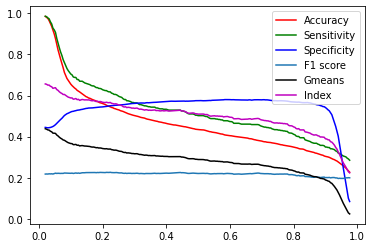

0.02


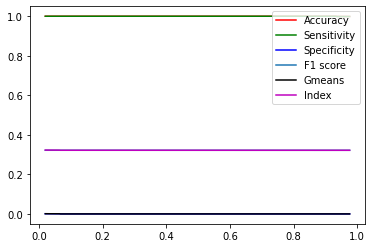

0.216


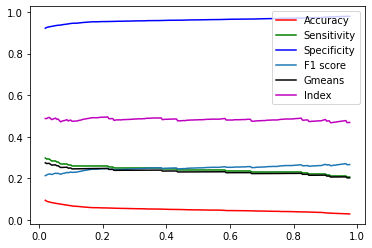

0.132


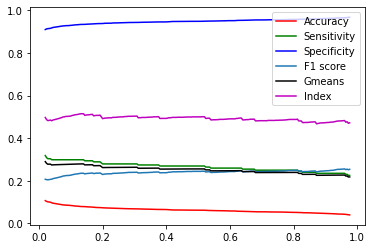

0.4905662039915721 0.07275855290987424 0.16178950667381287 0.010849572633494576 0.7383607228597006 0.06814970543707641 0.5381748775641123 0.07381736377283916 0.6625900268554688 0.015262480093080953 0.26080554723739624 0.008911841962801441
0.52920157 0.055869862 0.1561547 0.007233722 0.75764656 0.04661321 0.5418348 0.05272191 0.25850615 0.0070968457


In [192]:
accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
specificity=[]
auclist=[]
flist=[]


accuracyresultlist_T=[]
precisionresultlist_T=[]
recallresultlist_T=[]
specificity_T=[]
flist_T=[]


for train_index, validate_index in kfold.split(train_feature_df, train_label_df[antibitics_abx_list]):
    X=train_feature_df
    Y=train_label_df[antibitics_abx_list]
    x_train_tfidf = X.iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_val_tfidf = X.iloc[validate_index]
    y_val_tfidf = Y.iloc[validate_index]
    x_train_tfidf=x_train_tfidf.reset_index(drop=True)
    y_train_tfidf=y_train_tfidf.reset_index(drop=True)
    x_val_tfidf=x_val_tfidf.reset_index(drop=True)
    y_val_tfidf=y_val_tfidf.reset_index(drop=True)
    sample_size = x_train_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_train_tfidf.values.shape[1] # number of features in train set
    input_dimension = 1               # each feature is represented by 1 number
    train_data_reshaped = x_train_tfidf.values.reshape(sample_size,time_steps,input_dimension)
    #x_test_tfidf = (x_test_tfidf.values)
    #y_test_tfidf=(y_test_tfidf.values)
    sample_size = x_val_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_val_tfidf.values.shape[1] # number of features in train set

    x_val_reshaped = x_val_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    x_test_tfidf=test_feature_df.reset_index(drop=True)
    y_test_tfidf =test_label_df[antibitics_abx_list].reset_index(drop=True)
    sample_size = x_test_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_test_tfidf.values.shape[1] # number of features in train set
    test_data_reshaped =x_test_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    #model = Tran_Model(train_data_reshaped)
    model=build_conv1D_model(train_data_reshaped)
    model.compile(loss=masked_f1_loss,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=METRICS)
    
    history = model.fit(train_data_reshaped, y_train_tfidf, epochs=EPOCHS,validation_data=(x_val_reshaped, y_val_tfidf), callbacks=[es], verbose=1)
    results = model.evaluate(test_data_reshaped, y_test_tfidf, verbose=0)
    print(results)
    if (results[6] > best_result):
        model.save('output/Best_Model_F1_Masking')
        best_result=results[6]
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    specificity.append(results[4])
    auclist.append(results[6])
    flist.append(results[5])

    ypredict = model.predict(x_val_reshaped)
    ytrain = model.predict(train_data_reshaped)
    Threshold_list =get_threshold(y_val_tfidf, ypredict, label_count=4)
    
    ypredictTest = model.predict(test_data_reshaped)
    accuracyresultlist_T.append(masked_accuracy(y_test_tfidf,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    precisionresultlist_T.append(masked_precision(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    recallresultlist_T.append(masked_recall(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    specificity_T.append(masked_specificity(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    flist_T.append(masked_f1(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())

    


print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))
    


In [81]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))

0.6050613125165304 0.10272810489617264 0.14425918459892273 0.015094555376583822 0.805177370707194 0.04084644220282219 0.417751948038737 0.11003116426661587 0.6133061051368713 0.03373355394362448 0.24101391434669495 0.019809441261321788
0.60289264 0.104492426 0.14441465 0.014921231 0.7878434 0.047122568 0.41769707 0.11002617 0.24326408 0.019663604


In [193]:
print (Threshold_list)

[0.02, 0.02, 0.216, 0.132]


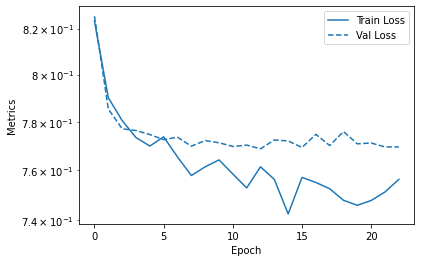

In [194]:
plot_metric(history, ['Loss',], 0,['loss',])

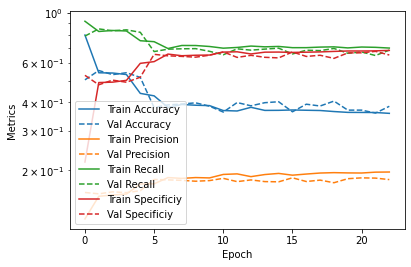

In [195]:
plot_metric(history, ['Accuracy', 'Precision','Recall', 'Specificiy'], 0,['masked_accuracy', 'masked_precision','masked_recall', 'masked_specificity'])

Epoch 1/100
  1/248 [..............................] - ETA: 28s - loss: 0.4597 - masked_accuracy: 0.3359 - masked_precision: 0.0698 - masked_recall: 0.3000 - masked_specificity: 0.6610 - masked_f1: 0.1132 - masked_AUC: 0.3750

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.2014 - masked_accuracy: 0.3615 - masked_precision: 0.1421 - masked_recall: 0.4834 - masked_specificity: 0.6531 - masked_f1: 0.2140 - masked_AUC: 0.5998 - ETA: 17s - loss: 0.2673 - masked_accuracy: 0.3289 - masked_precision: 0.1384 - masked_recall: 0.4426 - maske - ETA: 11s - loss: 0.2211 - masked_accuracy: 0.3505 - masked_precision: 0.1385 - masked_recall: 0.4646 - masked_specificity: 0.6633 - masked_f1: 0.2084 - masked_AUC: 0.6 - ETA: 11s - loss: 0.2139 - masked_accuracy: 0.3510 - masked_precision: 0.1390 - masked_recall: 0.4644 - masked_specificity: 0.6627 - masked_f1: 0.2090 - maske - ETA: 10s - loss: 0.2096 - masked_accuracy: 0.3575 - masked_precision: 0.1386 - masked_recall: 0.4684 - masked_spec - ETA: 7s - loss: 0.2220 - masked_accuracy: 0.3563 - masked_precision: 0.1375 - masked_recall:  - ETA: 4s - loss: 0.2189 - masked_accuracy: 0.3585 - masked_precision: 0.1380 - maske

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 27s 108ms/step - loss: 0.2019 - masked_accuracy: 0.3619 - masked_precision: 0.1423 - masked_recall: 0.4834 - masked_specificity: 0.6527 - masked_f1: 0.2142 - masked_AUC: 0.5999 - val_loss: 0.2452 - val_masked_accuracy: 0.4031 - val_masked_precision: 0.1377 - val_masked_recall: 0.5479 - val_masked_specificity: 0.6136 - val_masked_f1: 0.2156 - val_masked_AUC: 0.6134
Epoch 2/100
248/248 [==============================] - 27s 108ms/step - loss: 0.1264 - masked_accuracy: 0.3894 - masked_precision: 0.1402 - masked_recall: 0.5218 - masked_specificity: 0.6260 - masked_f1: 0.2165 - masked_AUC: 0.5912 - val_loss: 0.1466 - val_masked_accuracy: 0.3247 - val_masked_precision: 0.1507 - val_masked_recall: 0.4807 - val_masked_specificity: 0.6932 - val_masked_f1: 0.2231 - val_masked_AUC: 0.6004
Epoch 3/100
248/248 [==============================] - 27s 108ms/step - loss: 0.0952 - masked_accuracy: 0.3622 - masked_precision: 0.1528 - masked_recall: 0.5348 - mask

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.13279098272323608, 0.4184979796409607, 0.13487276434898376, 0.5173047184944153, 0.5937767624855042, 0.2098066210746765, 0.5676013827323914]
0.024


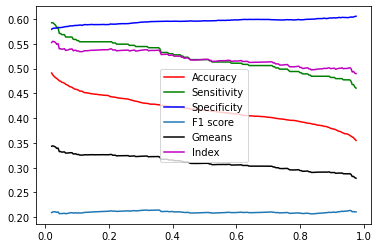

0.02


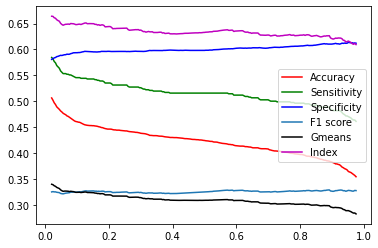

0.752


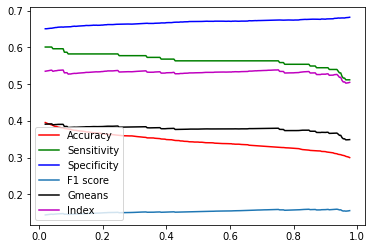

0.02


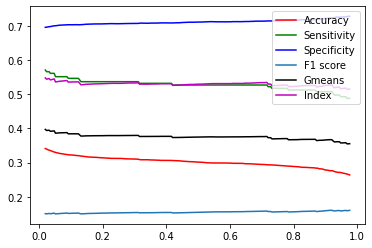

Epoch 1/100
  1/248 [..............................] - ETA: 26s - loss: 0.5863 - masked_accuracy: 0.5547 - masked_precision: 0.0704 - masked_recall: 0.7143 - masked_specificity: 0.4545 - masked_f1: 0.1282 - masked_AUC: 0.6458

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.1888 - masked_accuracy: 0.3872 - masked_precision: 0.1313 - masked_recall: 0.4808 - masked_specificity: 0.6240 - masked_f1: 0.2000 - masked_AUC: 0.5915 ETA: 8s - loss: 0.2415 - masked_accuracy: 0.3983 - masked_precision: 0.1213 - maske - ETA: 4s - loss: 0.2008 - masked_accuracy: 0.3905 - masked_precision: 0.1284 - masked_recall: 0.4783 - maske - ETA: 1s - loss: 0.1869 - masked_accuracy: 0.3860 - masked_precision: 0.1321 - masked_recall: 0.4820 - masked_specificity: 0.6256 - masked

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 27s 108ms/step - loss: 0.1893 - masked_accuracy: 0.3884 - masked_precision: 0.1315 - masked_recall: 0.4808 - masked_specificity: 0.6226 - masked_f1: 0.2003 - masked_AUC: 0.5908 - val_loss: 0.1268 - val_masked_accuracy: 0.4280 - val_masked_precision: 0.1310 - val_masked_recall: 0.5370 - val_masked_specificity: 0.5850 - val_masked_f1: 0.2064 - val_masked_AUC: 0.5881
Epoch 2/100
248/248 [==============================] - 27s 108ms/step - loss: 0.1309 - masked_accuracy: 0.4240 - masked_precision: 0.1347 - masked_recall: 0.5453 - masked_specificity: 0.5901 - masked_f1: 0.2114 - masked_AUC: 0.5769 - val_loss: 0.1435 - val_masked_accuracy: 0.4314 - val_masked_precision: 0.1259 - val_masked_recall: 0.5207 - val_masked_specificity: 0.5792 - val_masked_f1: 0.1988 - val_masked_AUC: 0.5622
Epoch 3/100
248/248 [==============================] - 27s 108ms/step - loss: 0.1073 - masked_accuracy: 0.3908 - masked_precision: 0.1425 - masked_recall: 0.5390 - mask

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.17397664487361908, 0.3950352966785431, 0.1418679654598236, 0.514813244342804, 0.6197282671928406, 0.21824052929878235, 0.5727289319038391]
0.02


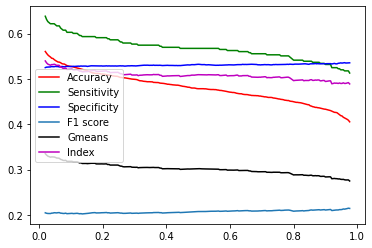

0.02


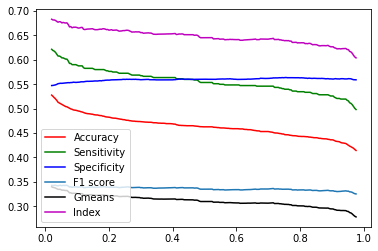

0.976


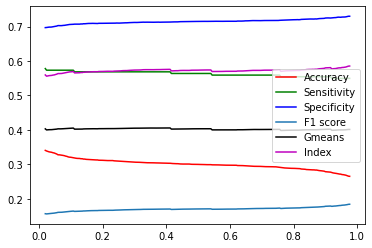

0.224


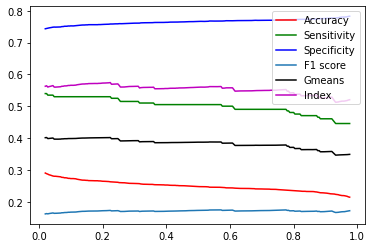

Epoch 1/100
  1/248 [..............................] - ETA: 30s - loss: 0.5916 - masked_accuracy: 0.4062 - masked_precision: 0.0577 - masked_recall: 0.4286 - masked_specificity: 0.5950 - masked_f1: 0.1017 - masked_AUC: 0.4156

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.1809 - masked_accuracy: 0.3793 - masked_precision: 0.1381 - masked_recall: 0.5043 - masked_specificity: 0.6349 - masked_f1: 0.2108 - masked_AUC: 0.5933 - ETA: 17s - loss: 0.2784 - mask - ETA: 7s - loss: 0.1943 - masked_accuracy: 0.3689 - masked_precision: 0.1393 - masked_recall: 0.4989 - masked_specificity: 0.6453 - masked_f1: 0.211 - ETA: 6s - loss: 0.1784 - masked_accuracy: 0.3687 - masked_precision - ETA: 1s - loss: 0.1719 - masked_accuracy: 0.3790 - masked_precision: 0.1402 - masked_recall: 0.5109 - masked_specificity: 0.6358 - masked_f1:

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 27s 109ms/step - loss: 0.1815 - masked_accuracy: 0.3777 - masked_precision: 0.1375 - masked_recall: 0.5023 - masked_specificity: 0.6364 - masked_f1: 0.2099 - masked_AUC: 0.5909 - val_loss: 0.1396 - val_masked_accuracy: 0.4205 - val_masked_precision: 0.1294 - val_masked_recall: 0.5119 - val_masked_specificity: 0.5907 - val_masked_f1: 0.2021 - val_masked_AUC: 0.5615
Epoch 2/100
248/248 [==============================] - 27s 108ms/step - loss: 0.1112 - masked_accuracy: 0.3644 - masked_precision: 0.1460 - masked_recall: 0.5206 - masked_specificity: 0.6536 - masked_f1: 0.2240 - masked_AUC: 0.6113 - val_loss: 0.1281 - val_masked_accuracy: 0.4354 - val_masked_precision: 0.1362 - val_masked_recall: 0.5592 - val_masked_specificity: 0.5793 - val_masked_f1: 0.2143 - val_masked_AUC: 0.5947
Epoch 3/100
248/248 [==============================] - 27s 109ms/step - loss: 0.0903 - masked_accuracy: 0.3637 - masked_precision: 0.1527 - masked_recall: 0.5333 - mask

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.14154984056949615, 0.42158517241477966, 0.13784056901931763, 0.5319473147392273, 0.5924467444419861, 0.21488627791404724, 0.5728684663772583]
0.024


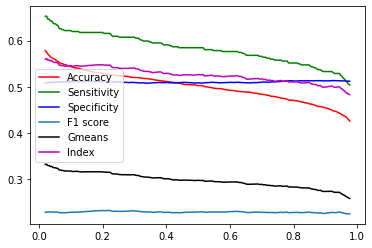

0.02


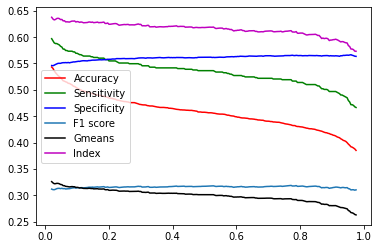

0.084


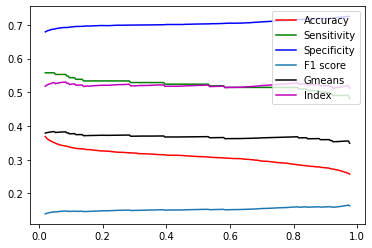

0.024


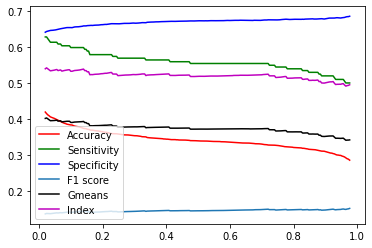

0.4117061495780945 0.011855257402085113 0.13819376627604166 0.0028666787835277007 0.5213550925254822 0.007558581852484123 0.601983924706777 0.012558888079657987 0.5710662603378296 0.002450700591370915 0.21431114276250204 0.0034670628602192187
0.44178715 0.029170955 0.13683224 0.0030928585 0.556205 0.026147721 0.5958239 0.015075149 0.21947962 0.0025664833


In [196]:
accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
specificity=[]
auclist=[]
flist=[]


accuracyresultlist_T=[]
precisionresultlist_T=[]
recallresultlist_T=[]
specificity_T=[]
flist_T=[]

for train_index, validate_index in kfold.split(train_feature_df, train_label_df[antibitics_abx_list]):
    X=train_feature_df
    Y=train_label_df[antibitics_abx_list]
    x_train_tfidf = X.iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_val_tfidf = X.iloc[validate_index]
    y_val_tfidf = Y.iloc[validate_index]
    x_train_tfidf=x_train_tfidf.reset_index(drop=True)
    y_train_tfidf=y_train_tfidf.reset_index(drop=True)
    x_val_tfidf=x_val_tfidf.reset_index(drop=True)
    y_val_tfidf=y_val_tfidf.reset_index(drop=True)
    sample_size = x_train_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_train_tfidf.values.shape[1] # number of features in train set
    input_dimension = 1               # each feature is represented by 1 number
    train_data_reshaped = x_train_tfidf.values.reshape(sample_size,time_steps,input_dimension)
    #x_test_tfidf = (x_test_tfidf.values)
    #y_test_tfidf=(y_test_tfidf.values)
    sample_size = x_val_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_val_tfidf.values.shape[1] # number of features in train set

    x_val_reshaped = x_val_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    x_test_tfidf=test_feature_df.reset_index(drop=True)
    y_test_tfidf =test_label_df[antibitics_abx_list].reset_index(drop=True)
    sample_size = x_test_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_test_tfidf.values.shape[1] # number of features in train set
    test_data_reshaped =x_test_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    #model = Tran_Model(train_data_reshaped)
    model=build_conv1D_model(train_data_reshaped)
    model.compile(loss=masked_TPTN_loss,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=METRICS)
    
    history = model.fit(train_data_reshaped, y_train_tfidf, epochs=EPOCHS,validation_data=(x_val_reshaped, y_val_tfidf), callbacks=[es], verbose=1)
    results = model.evaluate(test_data_reshaped, y_test_tfidf, verbose=0)
    print(results)
    if (results[6] > best_result):
        model.save('output/Best_Model_TPTN_Masking')
        best_result=results[6]
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    specificity.append(results[4])
    auclist.append(results[6])
    flist.append(results[5])
    
    ypredict = model.predict(x_val_reshaped)
    ytrain = model.predict(train_data_reshaped)
    Threshold_list =get_threshold(y_val_tfidf, ypredict, label_count=4)
    
    ypredictTest = model.predict(test_data_reshaped)
    accuracyresultlist_T.append(masked_accuracy(y_test_tfidf,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    precisionresultlist_T.append(masked_precision(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    recallresultlist_T.append(masked_recall(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    specificity_T.append(masked_specificity(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    flist_T.append(masked_f1(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())

    


print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))
    

In [197]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))

0.4117061495780945 0.011855257402085113 0.13819376627604166 0.0028666787835277007 0.5213550925254822 0.007558581852484123 0.601983924706777 0.012558888079657987 0.5710662603378296 0.002450700591370915 0.21431114276250204 0.0034670628602192187
0.44178715 0.029170955 0.13683224 0.0030928585 0.556205 0.026147721 0.5958239 0.015075149 0.21947962 0.0025664833


In [198]:
Threshold_list

[0.024, 0.02, 0.084, 0.024]

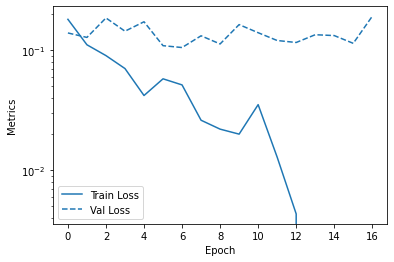

In [199]:
plot_metric(history, ['Loss',], 0,['loss',])

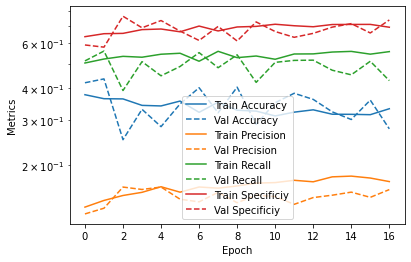

In [200]:
plot_metric(history, ['Accuracy', 'Precision','Recall', 'Specificiy'], 0,['masked_accuracy', 'masked_precision','masked_recall', 'masked_specificity'])

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
247/248 [============================>.] - ETA: 0s - loss: 0.7280 - masked_accuracy: 0.3668 - masked_precision: 0.1445 - masked_recall: 0.5015 - masked_specificity: 0.6489 - masked_f1: 0.2176 - masked_AUC: 0.6207 - ETA: 22s - loss: 0.7660 - masked_accuracy: 0.4961 - masked_precision: 0.1430 - masked_recall: 0.7032 - masked - ETA: 17s - loss: 0.7232 - masked_accuracy: 0.3672 - masked_precision: 0.1471 - masked_recall: 0.5125 - masked_specificity: 0.6498 - masked_f1: 0.2216 - masked_ - ETA: 15s - loss: 0.7178 - masked_accuracy: 0.3788 - masked_precision: 0.1451 - masked_recall: 0.5204 - mas - ETA: 9s - loss: 0.7329 - masked_accuracy: 0.3796 - masked_precision: 0.1398 - masked_recall: 0.5090 - masked_specificity: 0.6350 - masked_f1: 0.2 - ETA: 8s - loss: 0.7387 - masked_accuracy: 0.3782 - masked_precision: 0.1388 - masked_recall - ETA: 4s - loss: 0.7319 - masked_accuracy: 0.3734 - masked_precision: 0.1411 - masked_recall: 0.5070 - masked_specificity: 0.6418 - masked - ETA: 3s 

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 28s 114ms/step - loss: 0.7281 - masked_accuracy: 0.3673 - masked_precision: 0.1446 - masked_recall: 0.5015 - masked_specificity: 0.6483 - masked_f1: 0.2177 - masked_AUC: 0.6208 - val_loss: 0.7256 - val_masked_accuracy: 0.4138 - val_masked_precision: 0.1419 - val_masked_recall: 0.5824 - val_masked_specificity: 0.6052 - val_masked_f1: 0.2238 - val_masked_AUC: 0.6411
Epoch 2/100
248/248 [==============================] - 27s 111ms/step - loss: 0.6928 - masked_accuracy: 0.3916 - masked_precision: 0.1413 - masked_recall: 0.5251 - masked_specificity: 0.6240 - masked_f1: 0.2175 - masked_AUC: 0.5911 - val_loss: 0.7137 - val_masked_accuracy: 0.4350 - val_masked_precision: 0.1247 - val_masked_recall: 0.5320 - val_masked_specificity: 0.5763 - val_masked_f1: 0.1978 - val_masked_AUC: 0.5661ccuracy: 0.4224 - masked_precision: 0.1511 - masked_recall: 0.5667 - masked_specificity: 0.5964 - masked_f1: 0.2341 - masked_A - ETA: 21s - loss: 0.6942 - masked_accurac

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.717618465423584, 0.4731729030609131, 0.12740163505077362, 0.5502527952194214, 0.5366703867912292, 0.2033705711364746, 0.5505945086479187]
0.036


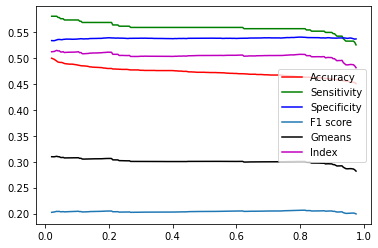

0.02


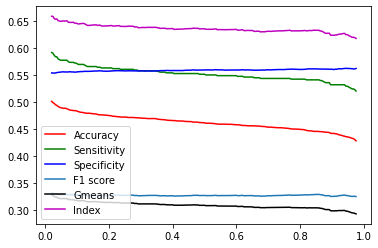

0.572


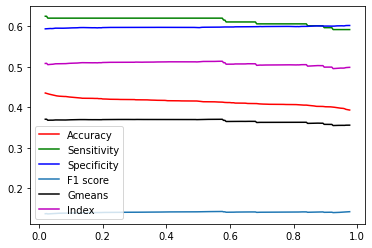

0.972


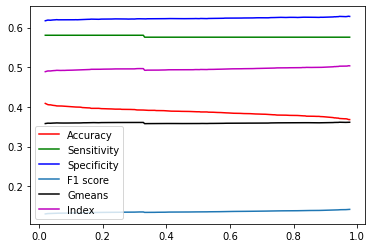

Epoch 1/100
  1/248 [..............................] - ETA: 27s - loss: 0.7572 - masked_accuracy: 0.4297 - masked_precision: 0.0364 - masked_recall: 0.2857 - masked_specificity: 0.5620 - masked_f1: 0.0645 - masked_AUC: 0.2857

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.7309 - masked_accuracy: 0.3774 - masked_precision: 0.1351 - masked_recall: 0.4768 - masked_specificity: 0.6345 - masked_f1: 0.2038 - masked_AUC: 0.5886 - ETA: 13s - loss: 0.7473 - masked_accuracy: 0.3763 - masked_precisio - ETA: 6s - loss: 0.7381 

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 27s 110ms/step - loss: 0.7310 - masked_accuracy: 0.3784 - masked_precision: 0.1354 - masked_recall: 0.4769 - masked_specificity: 0.6333 - masked_f1: 0.2041 - masked_AUC: 0.5882 - val_loss: 0.7009 - val_masked_accuracy: 0.3773 - val_masked_precision: 0.1414 - val_masked_recall: 0.5122 - val_masked_specificity: 0.6386 - val_masked_f1: 0.2171 - val_masked_AUC: 0.6012
Epoch 2/100
248/248 [==============================] - 27s 110ms/step - loss: 0.7051 - masked_accuracy: 0.3949 - masked_precision: 0.1375 - masked_recall: 0.5256 - masked_specificity: 0.6198 - masked_f1: 0.2131 - masked_AUC: 0.5883 - val_loss: 0.7083 - val_masked_accuracy: 0.4750 - val_masked_precision: 0.1290 - val_masked_recall: 0.5884 - val_masked_specificity: 0.5386 - val_masked_f1: 0.2078 - val_masked_AUC: 0.5760
Epoch 3/100
248/248 [==============================] - 27s 110ms/step - loss: 0.7041 - masked_accuracy: 0.3717 - masked_precision: 0.1435 - masked_recall: 0.5199 - mask

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.7223066091537476, 0.3993573784828186, 0.14260107278823853, 0.5197910070419312, 0.616126298904419, 0.21926090121269226, 0.5746235251426697]
0.02


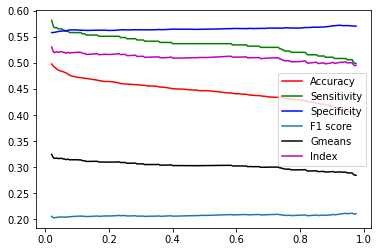

0.02


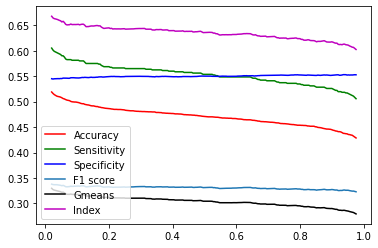

0.956


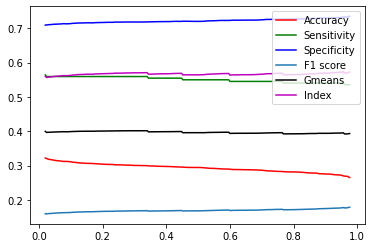

0.804


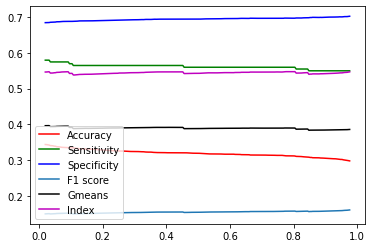

Epoch 1/100
  1/248 [..............................] - ETA: 32s - loss: 0.7497 - masked_accuracy: 0.2969 - masked_precision: 0.0263 - masked_recall: 0.1429 - masked_specificity: 0.6942 - masked_f1: 0.0444 - masked_AUC: 0.4835

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.7187 - masked_accuracy: 0.3624 - masked_precision: 0.1405 - masked_recall: 0.4880 - masked_specificity: 0.6516 - masked_f1: 0.2109 - masked_AUC: 0.5964 - ETA: 17s - loss: 0.7705 - masked_accuracy: 0.3772 - masked_precision: 0.1153 - masked_recall: 0.4272 - masked_specificity: 0.6285 - masked_f1: 0.1766 - ma - ETA: 16s - loss: 0.7639 - masked_accuracy: 0.3774 - masked_precision: 0.1210 - masked_recall: 0.4423 - masked_specificity: 0.6299 - masked_f1: 0.1848 - ma - ETA: 14s - loss: 0.7488 - masked_accuracy: 0.3751 - masked_precision: 0.1333 - masked_recall: 0.4519 - masked_specificity: 0.6344 - masked_f1: 0.1967 - masked_AUC: 0.563 - ETA: 14s - loss: 0.7445 - masked_accuracy: 0.3732 - masked_precision: 0.1340 - masked_recall: 0.4547 - masked_specificity: 0.6366 - masked_f - ETA: 11s - loss: 0.7310 - masked_accuracy: 0.3599 - masked_precision: 0.1363 - masked_recall: 0.4648 - m - ETA: 7s - loss: 0.7197 - masked_accuracy: 0.3642 

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 28s 111ms/step - loss: 0.7189 - masked_accuracy: 0.3621 - masked_precision: 0.1399 - masked_recall: 0.4860 - masked_specificity: 0.6518 - masked_f1: 0.2100 - masked_AUC: 0.5940 - val_loss: 0.7126 - val_masked_accuracy: 0.4883 - val_masked_precision: 0.1288 - val_masked_recall: 0.5917 - val_masked_specificity: 0.5241 - val_masked_f1: 0.2072 - val_masked_AUC: 0.5871
Epoch 2/100
248/248 [==============================] - 28s 112ms/step - loss: 0.6941 - masked_accuracy: 0.3684 - masked_precision: 0.1485 - masked_recall: 0.5258 - masked_specificity: 0.6498 - masked_f1: 0.2263 - masked_AUC: 0.6065 - val_loss: 0.7032 - val_masked_accuracy: 0.3193 - val_masked_precision: 0.1550 - val_masked_recall: 0.4685 - val_masked_specificity: 0.6983 - val_masked_f1: 0.2268 - val_masked_AUC: 0.6013ed_accuracy: 0.3791 - masked_precision: 0.1502 - masked_recall: 0.5378 - masked_specificity: 0.6400 - masked_f1: - ETA: 13s - loss: 0.6878 - masked_accuracy: 0.3625 - ma

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.7327290773391724, 0.39390119910240173, 0.14105942845344543, 0.5084201693534851, 0.6204826831817627, 0.21641045808792114, 0.5850001573562622]
0.02


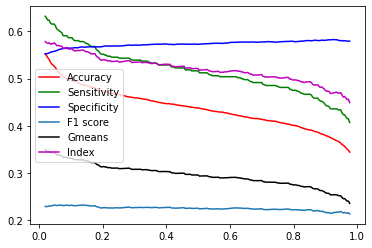

0.028


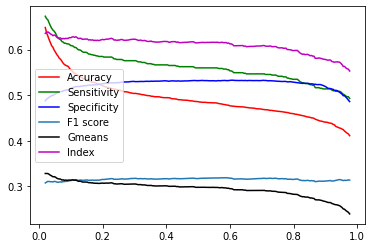

0.732


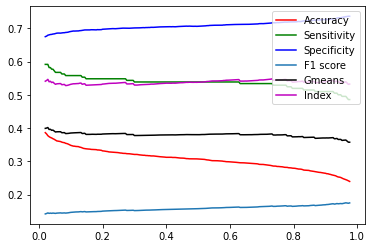

0.232


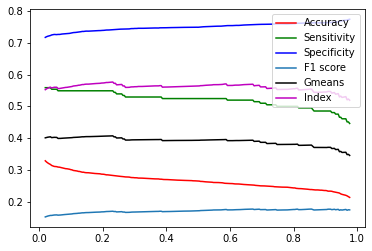

0.4221438268820445 0.036151693691162 0.13702071209748587 0.006830771027084698 0.5261546572049459 0.017660958434878863 0.591093122959137 0.03852376046021676 0.5700727303822836 0.01440993790118133 0.21301397681236267 0.0069175000915167465
0.43195465 0.031714346 0.13672803 0.0067426045 0.5421781 0.012160154 0.588567 0.0368668 0.21820505 0.0077285096


In [201]:
accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
specificity=[]
auclist=[]
flist=[]

accuracyresultlist_T=[]
precisionresultlist_T=[]
recallresultlist_T=[]
specificity_T=[]
flist_T=[]

for train_index, validate_index in kfold.split(train_feature_df, train_label_df[antibitics_abx_list]):
    X=train_feature_df
    Y=train_label_df[antibitics_abx_list]
    x_train_tfidf = X.iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_val_tfidf = X.iloc[validate_index]
    y_val_tfidf = Y.iloc[validate_index]
    x_train_tfidf=x_train_tfidf.reset_index(drop=True)
    y_train_tfidf=y_train_tfidf.reset_index(drop=True)
    x_val_tfidf=x_val_tfidf.reset_index(drop=True)
    y_val_tfidf=y_val_tfidf.reset_index(drop=True)
    sample_size = x_train_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_train_tfidf.values.shape[1] # number of features in train set
    input_dimension = 1               # each feature is represented by 1 number
    train_data_reshaped = x_train_tfidf.values.reshape(sample_size,time_steps,input_dimension)
    #x_test_tfidf = (x_test_tfidf.values)
    #y_test_tfidf=(y_test_tfidf.values)
    sample_size = x_val_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_val_tfidf.values.shape[1] # number of features in train set

    x_val_reshaped = x_val_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    x_test_tfidf=test_feature_df.reset_index(drop=True)
    y_test_tfidf =test_label_df[antibitics_abx_list].reset_index(drop=True)
    sample_size = x_test_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_test_tfidf.values.shape[1] # number of features in train set
    test_data_reshaped =x_test_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    #model = Tran_Model(train_data_reshaped)
    model=build_conv1D_model(train_data_reshaped)
    model.compile(loss=masked_SenSpeci_loss,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=METRICS)
    
    history = model.fit(train_data_reshaped, y_train_tfidf, epochs=EPOCHS,validation_data=(x_val_reshaped, y_val_tfidf), callbacks=[es], verbose=1)
    results = model.evaluate(test_data_reshaped, y_test_tfidf, verbose=0)
    print(results)
    if (results[6] > best_result):
        model.save('output/Best_Model_SpenSpeci_Masking')
        best_result=results[6]
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    specificity.append(results[4])
    auclist.append(results[6])
    flist.append(results[5])
    
    ypredict = model.predict(x_val_reshaped)
    ytrain = model.predict(train_data_reshaped)
    Threshold_list =get_threshold(y_val_tfidf, ypredict, label_count=4)
    
    ypredictTest = model.predict(test_data_reshaped)
    accuracyresultlist_T.append(masked_accuracy(y_test_tfidf,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    precisionresultlist_T.append(masked_precision(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    recallresultlist_T.append(masked_recall(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    specificity_T.append(masked_specificity(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())
    flist_T.append(masked_f1(y_test_tfidf.values,ypredictTest, model_threshold=np.mean(Threshold_list)).numpy())


print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))
    

In [202]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
#print(np.mean(accuracyresultlist_CT),np.std(accuracyresultlist_CT), np.mean(precisionresultlist_CT),np.std(precisionresultlist_CT), np.mean(recallresultlist_CT), np.std(recallresultlist_CT), np.mean(specificity_CT), np.std(specificity_CT), np.mean(flist_CT), np.std(flist_CT))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))


0.4221438268820445 0.036151693691162 0.13702071209748587 0.006830771027084698 0.5261546572049459 0.017660958434878863 0.591093122959137 0.03852376046021676 0.5700727303822836 0.01440993790118133 0.21301397681236267 0.0069175000915167465
0.43195465 0.031714346 0.13672803 0.0067426045 0.5421781 0.012160154 0.588567 0.0368668 0.21820505 0.0077285096


In [203]:
Threshold_list, np.mean(Threshold_list)

([0.02, 0.028, 0.732, 0.232], 0.253)

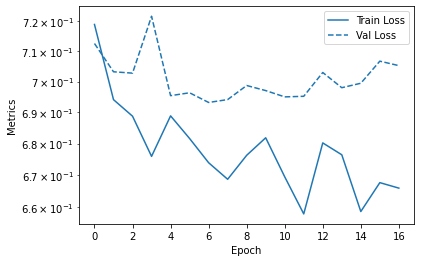

In [207]:
plot_metric(history, ['Loss',], 0,['loss',])

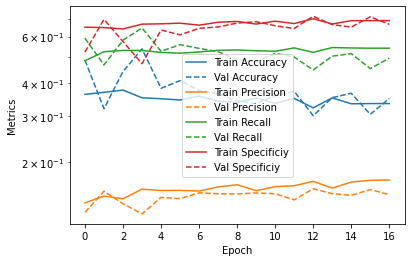

In [206]:
plot_metric(history, ['Accuracy', 'Precision','Recall', 'Specificiy'], 0,['masked_accuracy', 'masked_precision','masked_recall', 'masked_specificity'])

In [109]:
'''
accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
specificity=[]
auclist=[]
flist=[]

accuracyresultlist_CT=[]
precisionresultlist_CT=[]
recallresultlist_CT=[]
specificity_CT=[]
flist_CT=[]

accuracyresultlist_T=[]
precisionresultlist_T=[]
recallresultlist_T=[]
specificity_T=[]
flist_T=[]

for train_index, validate_index in kfold.split(train_feature_df, train_label_df[antibitics_abx_list]):
    X=train_feature_df
    Y=train_label_df[antibitics_abx_list]
    x_train_tfidf = X.iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_val_tfidf = X.iloc[validate_index]
    y_val_tfidf = Y.iloc[validate_index]
    x_train_tfidf=x_train_tfidf.reset_index(drop=True)
    y_train_tfidf=y_train_tfidf.reset_index(drop=True)
    x_val_tfidf=x_val_tfidf.reset_index(drop=True)
    y_val_tfidf=y_val_tfidf.reset_index(drop=True)
    sample_size = x_train_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_train_tfidf.values.shape[1] # number of features in train set
    input_dimension = 1               # each feature is represented by 1 number
    train_data_reshaped = x_train_tfidf.values.reshape(sample_size,time_steps,input_dimension)
    #x_test_tfidf = (x_test_tfidf.values)
    #y_test_tfidf=(y_test_tfidf.values)
    sample_size = x_val_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_val_tfidf.values.shape[1] # number of features in train set

    x_val_reshaped = x_val_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    x_test_tfidf=test_feature_df.reset_index(drop=True)
    y_test_tfidf =test_label_df[antibitics_abx_list].reset_index(drop=True)
    sample_size = x_test_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_test_tfidf.values.shape[1] # number of features in train set
    test_data_reshaped =x_test_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    #model = Tran_Model(train_data_reshaped)
    model=build_conv1D_model(train_data_reshaped)
    model.compile(loss=masked_f1_loss,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=METRICS)
    
    history = model.fit(train_data_reshaped, y_train_tfidf, epochs=EPOCHS,validation_data=(x_val_reshaped, y_val_tfidf), callbacks=[es], verbose=1)
    results = model.evaluate(test_data_reshaped, y_test_tfidf, verbose=0)
    print(results)
    if (results[6] > best_result):
        model.save('output/Best_Model_F1')
        best_result=results[6]
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    specificity.append(results[4])
    auclist.append(results[6])
    flist.append(results[5])
    
    ypredict = model.predict(test_data_reshaped)
    mask = K.cast(K.not_equal(y_test_tfidf, mask_value), K.floatx())
    mask_np=mask.numpy()
    Threshold_list=[0.5,0.5,0.5,0.5]
    for i in range(4):
        fpr, tpr, thres = roc_curve((y_test_tfidf.values*mask_np)[:, i], (ypredict*mask_np)[:, i])#test
        gmeans = sqrt(tpr * (1-fpr))
        ix = argmax(gmeans)
        Threshold_list[i]=thres[ix]
    
    accuracyresultlist_CT.append(masked_accuracy(y_test_tfidf,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    precisionresultlist_CT.append(masked_precision(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    recallresultlist_CT.append(masked_recall(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    specificity_CT.append(masked_specificity(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    flist_CT.append(masked_f1(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())

    accuracyresultlist_T.append(masked_accuracy(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    precisionresultlist_T.append(masked_precision(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    recallresultlist_T.append(masked_recall(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    specificity_T.append(masked_specificity(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    flist_T.append(masked_f1(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())


print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_CT),np.std(accuracyresultlist_CT), np.mean(precisionresultlist_CT),np.std(precisionresultlist_CT), np.mean(recallresultlist_CT), np.std(recallresultlist_CT), np.mean(specificity_CT), np.std(specificity_CT), np.mean(flist_CT), np.std(flist_CT))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))
'''

Epoch 1/100
  1/248 [..............................] - ETA: 34s - loss: 0.8745 - masked_accuracy: 0.4141 - masked_precision: 0.0943 - masked_recall: 0.5000 - masked_specificity: 0.5932 - masked_f1: 0.1587 - masked_AUC: 0.5220

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.8132 - masked_accuracy: 0.5707 - masked_precision: 0.1510 - masked_recall: 0.8340 - masked_specificity: 0.4584 - masked_f1: 0.2521 - masked_AUC: 0.6662 - ETA: 12s - loss: 0.8307 - masked_accuracy: 0.6317 - masked_precision: 0.1364 - masked_recall: 0.8402 - masked_specificity: 0.3910 - masked_f1: 0.2318 - ma - ETA: 11s - loss: 0.8220 - masked_accuracy: 0.6234 - masked_precision: 0.1396 - masked_recall: 0.8395 - masked - ETA: 8s - loss: 0.8153 - masked_accuracy: 0.5981 - masked_precision: 0.1448 - masked_recall: 0.8354 - masked_sp - ETA: 6s - loss: 0.8152 - masked_accuracy: 0.6086 - masked_precision: 0.1426 - masked_recall: 0.8479 - masked_specificity: 0.4172 - mask

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 19s 77ms/step - loss: 0.8131 - masked_accuracy: 0.5704 - masked_precision: 0.1517 - masked_recall: 0.8347 - masked_specificity: 0.4589 - masked_f1: 0.2531 - masked_AUC: 0.6667 - val_loss: 0.8734 - val_masked_accuracy: 0.5000 - val_masked_precision: 0.1501 - val_masked_recall: 0.7635 - val_masked_specificity: 0.5271 - val_masked_f1: 0.2469 - val_masked_AUC: 0.6450
Epoch 2/100
248/248 [==============================] - 19s 79ms/step - loss: 0.7918 - masked_accuracy: 0.5393 - masked_precision: 0.1567 - masked_recall: 0.8315 - masked_specificity: 0.4928 - masked_f1: 0.2603 - masked_AUC: 0.6677 - val_loss: 0.7954 - val_masked_accuracy: 0.5823 - val_masked_precision: 0.1464 - val_masked_recall: 0.8533 - val_masked_specificity: 0.4469 - val_masked_f1: 0.2464 - val_masked_AUC: 0.6567asked_accuracy: 0.5000 - masked_precision: 0.1546 - masked_recall: 0.7612 - masked_specificity: 0.5283 - masked_f1: 0.2523 - masked_A - ETA: 14s - loss: 0.8723 - masked_ac

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.7939348816871643, 0.5492061376571655, 0.15280863642692566, 0.7888619899749756, 0.4783276915550232, 0.2528356909751892, 0.6390718221664429]
Epoch 1/100
  2/248 [..............................] - ETA: 13s - loss: 0.8873 - masked_accuracy: 0.3945 - masked_precision: 0.0661 - masked_recall: 0.4571 - masked_specificity: 0.6075 - masked_f1: 0.1138 - masked_AUC: 0.5346

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.8201 - masked_accuracy: 0.7732 - masked_precision: 0.1214 - masked_recall: 0.8924 - masked_specificity: 0.2401 - masked_f1: 0.2101 - masked_AUC: 0.6643 ETA: 4s - loss: 0.8264 - masked_accuracy: 0.8374 - masked_precision: 0.1102 - masked_recall: 0. - ETA: 2s - loss: 0.8234 - masked_accuracy: 0.8120 - masked_precision: 0.1143 - masked_recall: 0.9038 - masked_specificity: 0.1980 - masked_f1: 0.2000 - masked_AUC - ETA: 2s - loss: 0.8227 - masked_accuracy: 0.8088 - masked_precision: 0.1153 - masked_recall: 0.9026 -

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 19s 77ms/step - loss: 0.8201 - masked_accuracy: 0.7723 - masked_precision: 0.1221 - masked_recall: 0.8915 - masked_specificity: 0.2412 - masked_f1: 0.2109 - masked_AUC: 0.6641 - val_loss: 0.7915 - val_masked_accuracy: 0.5188 - val_masked_precision: 0.1592 - val_masked_recall: 0.8160 - val_masked_specificity: 0.5139 - val_masked_f1: 0.2628 - val_masked_AUC: 0.6585
Epoch 2/100
248/248 [==============================] - 19s 77ms/step - loss: 0.7858 - masked_accuracy: 0.5456 - masked_precision: 0.1538 - masked_recall: 0.8322 - masked_specificity: 0.4855 - masked_f1: 0.2562 - masked_AUC: 0.6675 - val_loss: 0.7833 - val_masked_accuracy: 0.5279 - val_masked_precision: 0.1587 - val_masked_recall: 0.8258 - val_masked_specificity: 0.5050 - val_masked_f1: 0.2627 - val_masked_AUC: 0.6647recall: 0.8321 - masked_ - ETA: 1s - loss: 0.7839 - masked_accuracy: 0.5473 - masked_precision: 0.1553 - masked_recall: 0.8298 - masked_specificity: 0.4840 - masked
Epoch 

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.7906442284584045, 0.5457409024238586, 0.15417373180389404, 0.7906396389007568, 0.4824380576610565, 0.2547484040260315, 0.6336579918861389]
Epoch 1/100
  2/248 [..............................] - ETA: 16s - loss: 0.8913 - masked_accuracy: 0.4961 - masked_precision: 0.0637 - masked_recall: 0.4921 - masked_specificity: 0.5044 - masked_f1: 0.1125 - masked_AUC: 0.5140

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.8064 - masked_accuracy: 0.6519 - masked_precision: 0.1376 - masked_recall: 0.8593 - masked_specificity: 0.3707 - masked_f1: 0.2331 - masked_AUC: 0.6747 - ETA: 14s - loss: 0.8417 - masked_accuracy: 0.7486 - masked_precision: 0.1049 - masked_recall: 0.8008 - - ETA: 10s - loss: 0.8209 - masked_accuracy: 0.8212 - masked_precision: 0.1163 - masked_recall: 0.9064 - masked_specificity: 0.1887 - masked_f1: 0.2032 - masked_AUC: 0.667 - ETA: 10s - loss: 0.8197 - masked_accuracy: 0.8185 - masked_precision: 0.1174 - masked_recall: 0.9053 - masked_sp - ETA: 7s - loss: 0.8152 - masked_accuracy: 0.7403 - masked_pre - ETA: 4s - loss: 0.8048 - masked_accuracy: 0.6785 - masked - ETA: 0s - loss: 0.8046 - masked_accuracy: 0.6554 - masked_precision: 0.1376 - masked_recall: 0.8602 - masked_specificity: 0.3671 - masked_f1: 0.2331 - masked

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 19s 77ms/step - loss: 0.8065 - masked_accuracy: 0.6513 - masked_precision: 0.1370 - masked_recall: 0.8559 - masked_specificity: 0.3713 - masked_f1: 0.2322 - masked_AUC: 0.6720 - val_loss: 0.7792 - val_masked_accuracy: 0.5205 - val_masked_precision: 0.1611 - val_masked_recall: 0.8215 - val_masked_specificity: 0.5126 - val_masked_f1: 0.2656 - val_masked_AUC: 0.7001
Epoch 2/100
248/248 [==============================] - 19s 76ms/step - loss: 0.7873 - masked_accuracy: 0.5475 - masked_precision: 0.1520 - masked_recall: 0.8273 - masked_specificity: 0.4832 - masked_f1: 0.2536 - masked_AUC: 0.6672 - val_loss: 0.7773 - val_masked_accuracy: 0.5719 - val_masked_precision: 0.1544 - val_masked_recall: 0.8587 - val_masked_specificity: 0.4601 - val_masked_f1: 0.2583 - val_masked_AUC: 0.7010
Epoch 3/100
248/248 [==============================] - 19s 77ms/step - loss: 0.7805 - masked_accuracy: 0.5522 - masked_precision: 0.1534 - masked_recall: 0.8422 - masked_

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.7858175039291382, 0.3844127953052521, 0.1811773031949997, 0.6501437425613403, 0.6472182273864746, 0.2789873778820038, 0.676683783531189]
0.49311994512875873 0.07688057960615838 0.16271989047527313 0.013063254688292603 0.7432151238123575 0.06581540607337559 0.5359946588675181 0.07866483934155787 0.6498045325279236 0.019134575867582247 0.26219049096107483 0.011902833709655619
0.49606696 0.07321801 0.16247259 0.012307405 0.7342684 0.05923745 0.53454024 0.07714145 0.2650659 0.011859256
0.4177874 0.01572139 0.12890996 0.0072539514 0.49522698 0.013407099 0.576673 0.036757115 0.20452257 0.010112811


In [110]:
#print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
#print(np.mean(accuracyresultlist_CT),np.std(accuracyresultlist_CT), np.mean(precisionresultlist_CT),np.std(precisionresultlist_CT), np.mean(recallresultlist_CT), np.std(recallresultlist_CT), np.mean(specificity_CT), np.std(specificity_CT), np.mean(flist_CT), np.std(flist_CT))
#print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))


0.49311994512875873 0.07688057960615838 0.16271989047527313 0.013063254688292603 0.7432151238123575 0.06581540607337559 0.5359946588675181 0.07866483934155787 0.6498045325279236 0.019134575867582247 0.26219049096107483 0.011902833709655619
0.49606696 0.07321801 0.16247259 0.012307405 0.7342684 0.05923745 0.53454024 0.07714145 0.2650659 0.011859256
0.4177874 0.01572139 0.12890996 0.0072539514 0.49522698 0.013407099 0.576673 0.036757115 0.20452257 0.010112811


In [111]:
#Threshold_list, np.mean(Threshold_list)

([0.59642565, 0.9998255, 9.047062e-08, 8.618174e-08], 0.39906284)

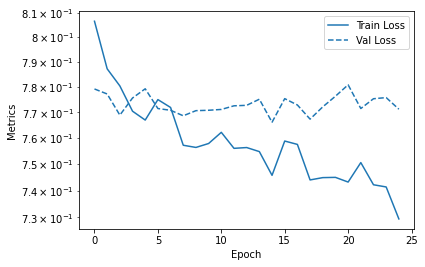

In [112]:
plot_metric(history, ['Loss',], 0,['loss',])

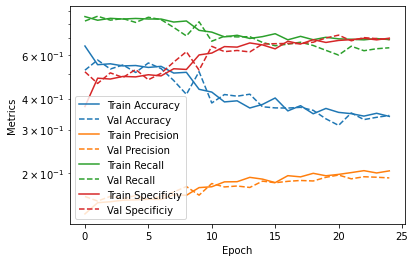

In [113]:
plot_metric(history, ['Accuracy', 'Precision','Recall', 'Specificiy'], 0,['masked_accuracy', 'masked_precision','masked_recall', 'masked_specificity'])

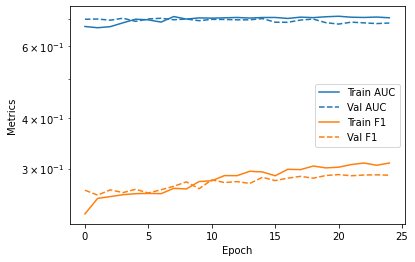

In [114]:
plot_metric(history, ['AUC', 'F1'], 0,['masked_AUC', 'masked_f1'])

In [115]:
'''
accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
specificity=[]
auclist=[]
flist=[]

accuracyresultlist_CT=[]
precisionresultlist_CT=[]
recallresultlist_CT=[]
specificity_CT=[]
flist_CT=[]

accuracyresultlist_T=[]
precisionresultlist_T=[]
recallresultlist_T=[]
specificity_T=[]
flist_T=[]

for train_index, validate_index in kfold.split(train_feature_df, train_label_df[antibitics_abx_list]):
    X=train_feature_df
    Y=train_label_df[antibitics_abx_list]
    x_train_tfidf = X.iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_val_tfidf = X.iloc[validate_index]
    y_val_tfidf = Y.iloc[validate_index]
    x_train_tfidf=x_train_tfidf.reset_index(drop=True)
    y_train_tfidf=y_train_tfidf.reset_index(drop=True)
    x_val_tfidf=x_val_tfidf.reset_index(drop=True)
    y_val_tfidf=y_val_tfidf.reset_index(drop=True)
    sample_size = x_train_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_train_tfidf.values.shape[1] # number of features in train set
    input_dimension = 1               # each feature is represented by 1 number
    train_data_reshaped = x_train_tfidf.values.reshape(sample_size,time_steps,input_dimension)
    #x_test_tfidf = (x_test_tfidf.values)
    #y_test_tfidf=(y_test_tfidf.values)
    sample_size = x_val_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_val_tfidf.values.shape[1] # number of features in train set

    x_val_reshaped = x_val_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    x_test_tfidf=test_feature_df.reset_index(drop=True)
    y_test_tfidf =test_label_df[antibitics_abx_list].reset_index(drop=True)
    sample_size = x_test_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_test_tfidf.values.shape[1] # number of features in train set
    test_data_reshaped =x_test_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    #model = Tran_Model(train_data_reshaped)
    model=build_conv1D_model(train_data_reshaped)
    model.compile(loss=masked_f1_double_loss,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=METRICS)
    
    history = model.fit(train_data_reshaped, y_train_tfidf, epochs=EPOCHS,validation_data=(x_val_reshaped, y_val_tfidf), callbacks=[es], verbose=1)
    results = model.evaluate(test_data_reshaped, y_test_tfidf, verbose=0)
    print(results)
    if (results[6] > best_result):
        model.save('output/Best_Model_Doble_F1')
        best_result=results[6]
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    specificity.append(results[4])
    auclist.append(results[6])
    flist.append(results[5])
    
    ypredict = model.predict(test_data_reshaped)
    mask = K.cast(K.not_equal(y_test_tfidf, mask_value), K.floatx())
    mask_np=mask.numpy()
    Threshold_list=[0.5,0.5,0.5,0.5]
    for i in range(4):
        fpr, tpr, thres = roc_curve((y_test_tfidf.values*mask_np)[:, i], (ypredict*mask_np)[:, i])#test
        gmeans = sqrt(tpr * (1-fpr))
        ix = argmax(gmeans)
        Threshold_list[i]=thres[ix]
    
    accuracyresultlist_CT.append(masked_accuracy(y_test_tfidf,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    precisionresultlist_CT.append(masked_precision(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    recallresultlist_CT.append(masked_recall(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    specificity_CT.append(masked_specificity(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    flist_CT.append(masked_f1(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())

    accuracyresultlist_T.append(masked_accuracy(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    precisionresultlist_T.append(masked_precision(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    recallresultlist_T.append(masked_recall(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    specificity_T.append(masked_specificity(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    flist_T.append(masked_f1(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())


print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_CT),np.std(accuracyresultlist_CT), np.mean(precisionresultlist_CT),np.std(precisionresultlist_CT), np.mean(recallresultlist_CT), np.std(recallresultlist_CT), np.mean(specificity_CT), np.std(specificity_CT), np.mean(flist_CT), np.std(flist_CT))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))
'''


Epoch 1/100
  1/248 [..............................] - ETA: 40s - loss: 0.6076 - masked_accuracy: 0.3203 - masked_precision: 0.1220 - masked_recall: 0.5000 - masked_specificity: 0.6949 - masked_f1: 0.1961 - masked_AUC: 0.5441

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.4939 - masked_accuracy: 0.0315 - masked_precision: 0.1684 - masked_recall: 0.0747 - masked_specificity: 0.9738 - masked_f1: 0.0906 - masked_AUC: 0.6389 - ETA: 14s - loss: 0.5248 - masked_accuracy: 0.0145 - masked_precision: 0.0418 - masked_recall: 0.0264 - masked_specificity: 0 - ETA: 11s - loss: 0.5155 - masked_accuracy: 0.0056 - masked_precision: 0.0162 - masked_recall: 0.0102 - masked_specificity: 0.9948 - masked_f1: 0.0079 - masked_AU - ETA: 11s - loss: 0.5142 - masked_accuracy: 0.0050 - masked_precision: 0.0144 - masked_recall: 0.0091 - masked_spec - ETA: 8s - loss: 0.5094 - masked_accuracy: 0.0065 - masked_precision: 0.0810 - masked_recall: 0.0156 - ETA: 6s - loss: 0.5041 - masked_accuracy: 0.0127 - masked_precision: 0.1275 - masked_recall:  - ETA: 3s - loss: 0.4998 - masked_accuracy: 0.0221 - masked_precision: 0.1405 - masked_recall: 0.0537 - masked_specificity: 0.9817 - masked_f1: 0.0675 - ma - ETA: 3s - loss: 0.4986 

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 20s 80ms/step - loss: 0.4939 - masked_accuracy: 0.0316 - masked_precision: 0.1677 - masked_recall: 0.0744 - masked_specificity: 0.9737 - masked_f1: 0.0903 - masked_AUC: 0.6388 - val_loss: 0.4749 - val_masked_accuracy: 0.0632 - val_masked_precision: 0.2647 - val_masked_recall: 0.1674 - val_masked_specificity: 0.9485 - val_masked_f1: 0.1935 - val_masked_AUC: 0.6376
Epoch 2/100
248/248 [==============================] - 20s 81ms/step - loss: 0.4517 - masked_accuracy: 0.0826 - masked_precision: 0.2702 - masked_recall: 0.2046 - masked_specificity: 0.9317 - masked_f1: 0.2139 - masked_AUC: 0.6137 - val_loss: 0.4649 - val_masked_accuracy: 0.0971 - val_masked_precision: 0.2362 - val_masked_recall: 0.2297 - val_masked_specificity: 0.9179 - val_masked_f1: 0.2213 - val_masked_AUC: 0.6221 - masked_precision: 0.2762 - masked_recall: 0.1772 - masked_specificity: 0.9473 - masked_f1: 0.2063 - maske - ETA: 12s - loss: 0.4627 - masked_accuracy: 0.0703 - masked_p

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.45686328411102295, 0.07818800210952759, 0.25943097472190857, 0.19206364452838898, 0.9365617036819458, 0.2111390084028244, 0.5787428617477417]
Epoch 1/100
  2/248 [..............................] - ETA: 12s - loss: 0.6102 - masked_accuracy: 0.2969 - masked_precision: 0.0656 - masked_recall: 0.3143 - masked_specificity: 0.7036 - masked_f1: 0.1065 - masked_AUC: 0.5484

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.4923 - masked_accuracy: 0.0374 - masked_precision: 0.1737 - masked_recall: 0.0869 - masked_specificity: 0.9688 - masked_f1: 0.1025 - masked_AUC: 0.6215 - ETA: 11s - loss: 0.

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 19s 78ms/step - loss: 0.4923 - masked_accuracy: 0.0384 - masked_precision: 0.1748 - masked_recall: 0.0885 - masked_specificity: 0.9680 - masked_f1: 0.1040 - masked_AUC: 0.6220 - val_loss: 0.4717 - val_masked_accuracy: 0.0531 - val_masked_precision: 0.2970 - val_masked_recall: 0.1477 - val_masked_specificity: 0.9587 - val_masked_f1: 0.1865 - val_masked_AUC: 0.6243
Epoch 2/100
248/248 [==============================] - 19s 78ms/step - loss: 0.4688 - masked_accuracy: 0.0779 - masked_precision: 0.2602 - masked_recall: 0.1953 - masked_specificity: 0.9352 - masked_f1: 0.2065 - masked_AUC: 0.5827 - val_loss: 0.4701 - val_masked_accuracy: 0.0664 - val_masked_precision: 0.2573 - val_masked_recall: 0.1664 - val_masked_specificity: 0.9459 - val_masked_f1: 0.1904 - val_masked_AUC: 0.5727racy: 0.0868 - masked_precision: 0.2558 - masked_recall: 0.1993 - masked_specificity: 0.9269 - masked_f1: 0.2093 - m - ETA: 10s - loss: 0.4703 - masked_accuracy: 0.0788 - 

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.45900049805641174, 0.07850302755832672, 0.23563213646411896, 0.17332205176353455, 0.933667778968811, 0.18951131403446198, 0.5716841220855713]
Epoch 1/100
  2/248 [..............................] - ETA: 16s - loss: 0.6116 - masked_accuracy: 0.3203 - masked_precision: 0.0652 - masked_recall: 0.3254 - masked_specificity: 0.6802 - masked_f1: 0.1048 - masked_AUC: 0.5054

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


247/248 [============================>.] - ETA: 0s - loss: 0.5006 - masked_accuracy: 0.0366 - masked_precision: 0.2307 - masked_recall: 0.0940 - masked_specificity: 0.9697 - masked_f1: 0.1184 - masked_AUC: 0.5815 - ETA: 12s - loss: 0.5181 - masked_accuracy: 0.0146 - maske - ETA: 7s - loss: 0.5073 - masked_accuracy: 0.018 - ETA: 3s - loss: 0.5032 - masked_accuracy: 0.0296 - masked_precision: 0.2238 - masked_reca - ETA: 0s - loss: 0.4999 - masked_accuracy: 0.0357 - masked_precision: 0.2373 - masked_recall: 0.0955 - masked_specificity: 0.9709 - masked_f1: 0

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


248/248 [==============================] - 19s 79ms/step - loss: 0.5006 - masked_accuracy: 0.0365 - masked_precision: 0.2298 - masked_recall: 0.0936 - masked_specificity: 0.9699 - masked_f1: 0.1180 - masked_AUC: 0.5792 - val_loss: 0.4876 - val_masked_accuracy: 0.0475 - val_masked_precision: 0.2911 - val_masked_recall: 0.1263 - val_masked_specificity: 0.9615 - val_masked_f1: 0.1642 - val_masked_AUC: 0.4792
Epoch 2/100
248/248 [==============================] - 19s 79ms/step - loss: 0.4576 - masked_accuracy: 0.0870 - masked_precision: 0.2578 - masked_recall: 0.2126 - masked_specificity: 0.9276 - masked_f1: 0.2172 - masked_AUC: 0.6028 - val_loss: 0.4497 - val_masked_accuracy: 0.0628 - val_masked_precision: 0.2827 - val_masked_recall: 0.1705 - val_masked_specificity: 0.9498 - val_masked_f1: 0.1975 - val_masked_AUC: 0.6002d_accuracy: 0.0870 - masked_precision: 0.2594 - masked_recall: 0.2042 - masked_specificity: 0.9272 - masked_f1: 0.2144 - masked_AUC: 0. - ETA: 9s - loss: 0.4595 - masked_a

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.4597523510456085, 0.08001512289047241, 0.2524595558643341, 0.1862659901380539, 0.9339419603347778, 0.20216400921344757, 0.5794373750686646]
0.07890205085277557 0.0007974991240014908 0.24917422235012054 0.00998970262586492 0.18388389547665915 0.007834437060091173 0.9347238143285116 0.0013043955974476108 0.5766214529673258 0.003502714601103954 0.20093811055024466 0.008871918679074104
0.28387466 0.036847927 0.17196989 0.011023653 0.44691214 0.039166626 0.78850824 0.0231469 0.2475755 0.011574889
0.39499283 0.021338308 0.13933885 0.0011819655 0.50711083 0.02825732 0.7202406 0.010920524 0.21849883 0.0034100283


In [116]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_CT),np.std(accuracyresultlist_CT), np.mean(precisionresultlist_CT),np.std(precisionresultlist_CT), np.mean(recallresultlist_CT), np.std(recallresultlist_CT), np.mean(specificity_CT), np.std(specificity_CT), np.mean(flist_CT), np.std(flist_CT))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))


0.07890205085277557 0.0007974991240014908 0.24917422235012054 0.00998970262586492 0.18388389547665915 0.007834437060091173 0.9347238143285116 0.0013043955974476108 0.5766214529673258 0.003502714601103954 0.20093811055024466 0.008871918679074104
0.28387466 0.036847927 0.17196989 0.011023653 0.44691214 0.039166626 0.78850824 0.0231469 0.2475755 0.011574889
0.39499283 0.021338308 0.13933885 0.0011819655 0.50711083 0.02825732 0.7202406 0.010920524 0.21849883 0.0034100283


In [118]:
Threshold_list, np.mean(Threshold_list)

([2.8136601e-05, 0.00023391843, 7.722331e-09, 1.7183835e-07], 6.555864e-05)

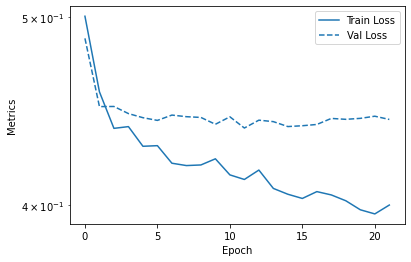

In [119]:
plot_metric(history, ['Loss',], 0,['loss',])

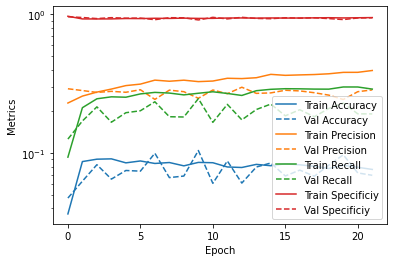

In [120]:
plot_metric(history, ['Accuracy', 'Precision','Recall', 'Specificiy'], 0,['masked_accuracy', 'masked_precision','masked_recall', 'masked_specificity'])

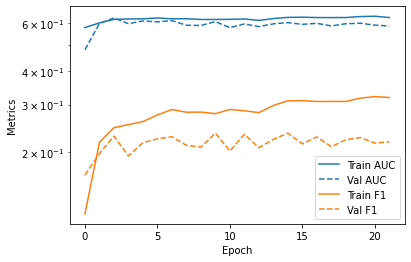

In [121]:
plot_metric(history, ['AUC', 'F1'], 0,['masked_AUC', 'masked_f1'])

Tranformer

In [127]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_CT),np.std(accuracyresultlist_CT), np.mean(precisionresultlist_CT),np.std(precisionresultlist_CT), np.mean(recallresultlist_CT), np.std(recallresultlist_CT), np.mean(specificity_CT), np.std(specificity_CT), np.mean(flist_CT), np.std(flist_CT))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))


1.0 0.0 0.10814012587070465 0.0 1.0 0.0 0.0 0.0 0.5216501553853353 0.030617943373426066 0.19360965490341187 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.114416815 0.089691654 0.050215792 0.03555712 0.3642588 0.2580283 0.0 0.0 0.08822418 0.062431447


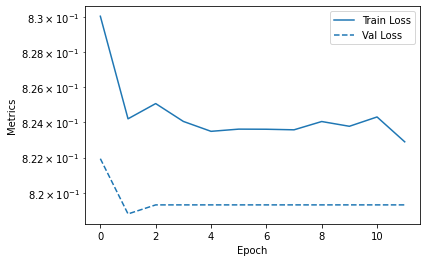

In [128]:
plot_metric(history, ['Loss',], 0,['loss',])

In [173]:
accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
specificity=[]
auclist=[]
flist=[]

accuracyresultlist_CT=[]
precisionresultlist_CT=[]
recallresultlist_CT=[]
specificity_CT=[]
flist_CT=[]

accuracyresultlist_T=[]
precisionresultlist_T=[]
recallresultlist_T=[]
specificity_T=[]
flist_T=[]

for train_index, validate_index in kfold.split(train_feature_df, train_label_df[antibitics_abx_list]):
    X=train_feature_df
    Y=train_label_df[antibitics_abx_list]
    x_train_tfidf = X.iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_val_tfidf = X.iloc[validate_index]
    y_val_tfidf = Y.iloc[validate_index]
    x_train_tfidf=x_train_tfidf.reset_index(drop=True)
    y_train_tfidf=y_train_tfidf.reset_index(drop=True)
    x_val_tfidf=x_val_tfidf.reset_index(drop=True)
    y_val_tfidf=y_val_tfidf.reset_index(drop=True)
    sample_size = x_train_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_train_tfidf.values.shape[1] # number of features in train set
    input_dimension = 1               # each feature is represented by 1 number
    train_data_reshaped = x_train_tfidf.values.reshape(sample_size,time_steps,input_dimension)
    #x_test_tfidf = (x_test_tfidf.values)
    #y_test_tfidf=(y_test_tfidf.values)
    sample_size = x_val_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_val_tfidf.values.shape[1] # number of features in train set

    x_val_reshaped = x_val_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    x_test_tfidf=test_feature_df.reset_index(drop=True)
    y_test_tfidf =test_label_df[antibitics_abx_list].reset_index(drop=True)
    sample_size = x_test_tfidf.values.shape[0] # number of samples in train set
    time_steps  = x_test_tfidf.values.shape[1] # number of features in train set
    test_data_reshaped =x_test_tfidf.values.reshape(sample_size,time_steps,input_dimension)

    #model = Tran_Model(train_data_reshaped)
    model=build_conv1D_model(train_data_reshaped)
    model.compile(loss=masked_f1_loss,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=METRICS)
    
    history = model.fit(train_data_reshaped, y_train_tfidf, epochs=EPOCHS,validation_data=(x_val_reshaped, y_val_tfidf), callbacks=[es], verbose=1)
    results = model.evaluate(test_data_reshaped, y_test_tfidf, verbose=0)
    print(results)
    if (results[6] > best_result):
        model.save('output/Best_Model_F1_IDCNN_fulltrain')
        best_result=results[6]
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    specificity.append(results[4])
    auclist.append(results[6])
    flist.append(results[5])
    
    ypredict = model.predict(test_data_reshaped)
    mask = K.cast(K.not_equal(y_test_tfidf, mask_value), K.floatx())
    mask_np=mask.numpy()
    Threshold_list=[0.5,0.5,0.5,0.5]
    for i in range(4):
        fpr, tpr, thres = roc_curve((y_test_tfidf.values*mask_np)[:, i], (ypredict*mask_np)[:, i])#test
        gmeans = sqrt(tpr * (1-fpr))
        ix = argmax(gmeans)
        Threshold_list[i]=thres[ix]
    
    accuracyresultlist_CT.append(masked_accuracy(y_test_tfidf,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    precisionresultlist_CT.append(masked_precision(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    recallresultlist_CT.append(masked_recall(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    specificity_CT.append(masked_specificity(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())
    flist_CT.append(masked_f1(y_test_tfidf.values,ypredict, model_threshold=np.mean(Threshold_list)).numpy())

    accuracyresultlist_T.append(masked_accuracy(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    precisionresultlist_T.append(masked_precision(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    recallresultlist_T.append(masked_recall(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    specificity_T.append(masked_specificity(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())
    flist_T.append(masked_f1(y_test_tfidf.values,ypredict, model_threshold=Threshold_list).numpy())


print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_CT),np.std(accuracyresultlist_CT), np.mean(precisionresultlist_CT),np.std(precisionresultlist_CT), np.mean(recallresultlist_CT), np.std(recallresultlist_CT), np.mean(specificity_CT), np.std(specificity_CT), np.mean(flist_CT), np.std(flist_CT))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))


C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
1687/1687 [==============================] - ETA: 0s - loss: 0.5400 - masked_accuracy: 0.5485 - masked_precision: 0.3250 - masked_recall: 0.7329 - masked_specificity: 0.5652 - masked_f1: 0.4449 - masked_AUC: 0.6785   ETA: 1:44 - loss: 0.5598 -  - ETA: 1:02 - loss: 0.5450 - masked - ETA: 53s - loss: 0.5437 - masked_accuracy: 0.5562 - masked_precision: 0.3228 - masked_recall: 0.7350 - masked_specificity:  - ETA: 49s - loss: 0.5445 - masked_accuracy: 0.5537 - mask - ETA: 40s - loss: 0.5428 - masked_accuracy: 0.5539 - masked_precision: 0.3231 - masked_recall: 0.7348 - masked_specificity: 0.5594 - masked_f - ETA: 37s - loss: 0.5426 - masked_accuracy: 0.5536 - masked_precision: 0.3233 - masked_recall: 0.7347 - masked_specificity: 0.5597 - masked_f1: 0.4432 - masked_AUC: - ETA: 36s - loss: 0.5428 - masked_accuracy: 0.5534 - masked_precision: 0.3231 - masked_recall: 0.7346 - masked_specificity: 0.5599 - masked_f1: 0.4430 - masked_AUC: 0.6 - ETA: 36s - loss: 0.5426 - masked_accuracy

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1687/1687 [==============================] - 171s 102ms/step - loss: 0.5400 - masked_accuracy: 0.5485 - masked_precision: 0.3250 - masked_recall: 0.7329 - masked_specificity: 0.5652 - masked_f1: 0.4449 - masked_AUC: 0.6785 - val_loss: 0.5266 - val_masked_accuracy: 0.4943 - val_masked_precision: 0.3406 - val_masked_recall: 0.6946 - val_masked_specificity: 0.6224 - val_masked_f1: 0.4532 - val_masked_AUC: 0.6832
Epoch 2/100
1687/1687 [==============================] - 175s 104ms/step - loss: 0.5220 - masked_accuracy: 0.5282 - masked_precision: 0.3370 - masked_recall: 0.7342 - masked_specificity: 0.5912 - masked_f1: 0.4570 - masked_AUC: 0.6868 - val_loss: 0.5187 - val_masked_accuracy: 0.5386 - val_masked_precision: 0.3366 - val_masked_recall: 0.7499 - val_masked_specificity: 0.5841 - val_masked_f1: 0.4608 - val_masked_AUC: 0.6923on: 0.3335 - - ETA: 2:08 - loss: 0.5264 - masked_accuracy: 0.5217 - masked_precision: 0.3402 - masked_re - ETA: 2:05 - loss: 0.5249 - masked_a - ETA: 1:59 - loss: 

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.806150496006012, 0.2777217626571655, 0.2081671506166458, 0.5431232452392578, 0.7536754608154297, 0.29534536600112915, 0.6489092707633972]
Epoch 1/100
   1/1687 [..............................] - ETA: 3:23 - loss: 0.6737 - masked_accuracy: 0.4583 - masked_precision: 0.3462 - masked_recall: 0.6207 - masked_specificity: 0.6264 - masked_f1: 0.4444 - masked_AUC: 0.6334

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1687/1687 [==============================] - ETA: 0s - loss: 0.5438 - masked_accuracy: 0.5592 - masked_precision: 0.3214 - masked_recall: 0.7375 - masked_specificity: 0.5538 - masked_f1: 0.4420 - masked_AUC: 0.6779   ETA: 2:33 - loss: 0.6423 - masked_accurac - ETA: 1:06 - loss: 0.5505 - masked_accuracy: 0.5729 - masked_precision: 0.3149 - masked_recall: 0.7433 - masked_specif - ETA: 1:04 - loss: 0.5499 - masked_accur - ETA: 41s - loss: 0.5472 - masked_accuracy: 0.5659 - masked_precision: 0.3185 - masked_re - ETA: 33s - loss: 0.5464 - masked_accuracy: 0.5647 - masked_precision: 0.3191 - masked_recall: 0.7387 - masked_specificity: 0.5476 - masked_f1 - ETA: 30s - loss: 0.5459 - masked_accuracy: 0.5636 - masked_precision: 0.3194 - masked_recall: 0.7383 - masked_sp - ETA: 25s - loss: 0.5449 - masked_accuracy: 0.5628 - masked_precision: 0.3202 - masked_recall: 0.7387 - masked_specificity: 0.549 - ETA: 21s - loss: 0.5445 - masked_accuracy: 0.5613 - masked_precision: 0.3207 - masked_recall: 0.

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1687/1687 [==============================] - 182s 108ms/step - loss: 0.5438 - masked_accuracy: 0.5592 - masked_precision: 0.3214 - masked_recall: 0.7375 - masked_specificity: 0.5538 - masked_f1: 0.4420 - masked_AUC: 0.6779 - val_loss: 0.5257 - val_masked_accuracy: 0.5428 - val_masked_precision: 0.3331 - val_masked_recall: 0.7505 - val_masked_specificity: 0.5780 - val_masked_f1: 0.4571 - val_masked_AUC: 0.6898
Epoch 2/100
1687/1687 [==============================] - 183s 108ms/step - loss: 0.5286 - masked_accuracy: 0.5294 - masked_precision: 0.3336 - masked_recall: 0.7278 - masked_specificity: 0.5881 - masked_f1: 0.4531 - masked_AUC: 0.6791 - val_loss: 0.5204 - val_masked_accuracy: 0.5218 - val_masked_precision: 0.3388 - val_masked_recall: 0.7325 - val_masked_specificity: 0.5986 - val_masked_f1: 0.4589 - val_masked_AUC: 0.6860masked_recall: 0.7301 - masked_specificity: 0.5843 - mas - ETA: 42s - loss: 0.5301 - masked_accuracy: 0.5336 - masked_precision: 0.3330 - masked_recall: 0.7294 - m

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.8115866184234619, 0.09192288666963577, 0.27638155221939087, 0.22897127270698547, 0.9257276058197021, 0.23996388912200928, 0.5804897546768188]
Epoch 1/100
   1/1687 [..............................] - ETA: 3:00 - loss: 0.6953 - masked_accuracy: 0.5948 - masked_precision: 0.2656 - masked_recall: 0.6296 - masked_specificity: 0.4719 - masked_f1: 0.3736 - masked_AUC: 0.6140

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1687/1687 [==============================] - ETA: 0s - loss: 0.5462 - masked_accuracy: 0.5803 - masked_precision: 0.3177 - masked_recall: 0.7615 - masked_specificity: 0.5327 - masked_f1: 0.4422 - masked_AUC: 0.6774   ETA: 2:15 - loss: 0.5737 - masked_accuracy: 0.6467 - masked_precision: 0.2936 - masked_recall: 0.7851 - - ETA: 1:05 - loss: 0.5549 - - ETA: 58s - loss: 0.5537 - masked_accuracy: 0.5984 - masked_precision: 0.3125 - masked_recall: 0.7702 - masked_specificity: 0.5128 - masked_f1: 0.4381 - mask - ETA: 56s - loss: 0.5536 - m - ETA: 42s - loss: 0.5508 - masked_accuracy: 0.5935 - masked_precision: 0.3149 - masked_recall: 0.7687 - masked_specificity: 0.5181 - masked_f1: 0.4405 -  - ETA: 41s - loss: 0.5505 - masked_accuracy: 0.5934 - masked_precision: 0.3148 - masked_recall: 0.7692 - masked_specificity: 0.5183 - masked_f1: 0.4405 - mas - ETA: 39s - loss: 0.5500 - masked_accuracy: 0.5929 - masked_precision: 0.3151 - masked_recall: 0.7690 - masked_specificity: 0.5189 - ma - ETA: 36s 

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1687/1687 [==============================] - 189s 112ms/step - loss: 0.5462 - masked_accuracy: 0.5803 - masked_precision: 0.3177 - masked_recall: 0.7615 - masked_specificity: 0.5327 - masked_f1: 0.4422 - masked_AUC: 0.6774 - val_loss: 0.5338 - val_masked_accuracy: 0.5142 - val_masked_precision: 0.3329 - val_masked_recall: 0.7039 - val_masked_specificity: 0.5996 - val_masked_f1: 0.4475 - val_masked_AUC: 0.6740
Epoch 2/100
1687/1687 [==============================] - 187s 111ms/step - loss: 0.5248 - masked_accuracy: 0.5296 - masked_precision: 0.3345 - masked_recall: 0.7337 - masked_specificity: 0.5887 - masked_f1: 0.4548 - masked_AUC: 0.6857 - val_loss: 0.5289 - val_masked_accuracy: 0.6007 - val_masked_precision: 0.3211 - val_masked_recall: 0.7970 - val_masked_specificity: 0.5199 - val_masked_f1: 0.4535 - val_masked_AUC: 0.6894all: 0 - ETA: 46s - loss: 0.5248 - masked_accuracy: 0.5357 - masked_precision: 0.3330 - masked_recall: 0.7408 - masked_specificity: 0.5823 - masked_f1: 0.4546 - ma

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0.8351722359657288, 0.07150957733392715, 0.28646788001060486, 0.18883904814720154, 0.9437145590782166, 0.21597059071063995, 0.5803106427192688]
0.14705140888690948 0.092772955165974 0.2570055276155472 0.034778573892489874 0.32031118869781494 0.15840151149783807 0.8743725419044495 0.08566104388591918 0.6032365560531616 0.03229556906682672 0.25042661527792615 0.03323843374834012
0.18764274 0.06382985 0.23268496 0.017379627 0.3921683 0.100067355 0.8432739 0.06370054 0.2852155 0.0106906155
0.32157657 0.0400764 0.13546856 0.016161235 0.48259115 0.0153450705 0.7415857 0.0016558762 0.21074305 0.018901648


In [179]:
train_feature_df.shape

(80962, 790)

In [174]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(specificity), np.std(specificity), np.mean(auclist), np.std(auclist), np.mean(flist), np.std(flist))
print(np.mean(accuracyresultlist_CT),np.std(accuracyresultlist_CT), np.mean(precisionresultlist_CT),np.std(precisionresultlist_CT), np.mean(recallresultlist_CT), np.std(recallresultlist_CT), np.mean(specificity_CT), np.std(specificity_CT), np.mean(flist_CT), np.std(flist_CT))
print(np.mean(accuracyresultlist_T),np.std(accuracyresultlist_T), np.mean(precisionresultlist_T),np.std(precisionresultlist_T), np.mean(recallresultlist_T), np.std(recallresultlist_T), np.mean(specificity_T), np.std(specificity_T), np.mean(flist_T), np.std(flist_T))


0.14705140888690948 0.092772955165974 0.2570055276155472 0.034778573892489874 0.32031118869781494 0.15840151149783807 0.8743725419044495 0.08566104388591918 0.6032365560531616 0.03229556906682672 0.25042661527792615 0.03323843374834012
0.18764274 0.06382985 0.23268496 0.017379627 0.3921683 0.100067355 0.8432739 0.06370054 0.2852155 0.0106906155
0.32157657 0.0400764 0.13546856 0.016161235 0.48259115 0.0153450705 0.7415857 0.0016558762 0.21074305 0.018901648


In [175]:
Threshold_list, np.mean(Threshold_list)

([1.9587471e-17, 3.1174732e-06, 4.9072667e-23, 1.943978e-25], 7.793683e-07)

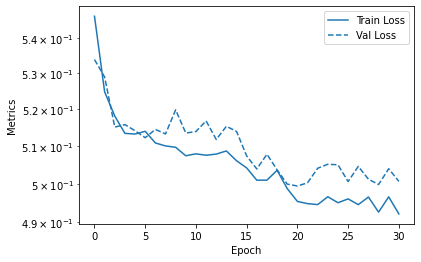

In [176]:
plot_metric(history, ['Loss',], 0,['loss',])

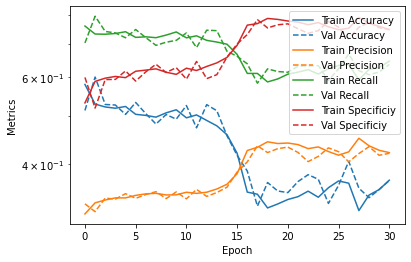

In [177]:
plot_metric(history, ['Accuracy', 'Precision','Recall', 'Specificiy'], 0,['masked_accuracy', 'masked_precision','masked_recall', 'masked_specificity'])

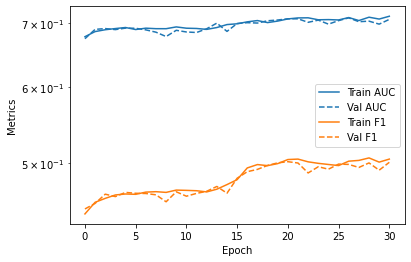

In [178]:
plot_metric(history, ['AUC', 'F1'], 0,['masked_AUC', 'masked_f1'])

In [230]:
import random, os, sys
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
#from keras.engine.topology import Layer

In [ ]:
corr = feature_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
s = corr.unstack()
so = s.sort_values(kind="quicksort")

In [ ]:
import seaborn as sns
kot = corr[corr>=.9]
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Greens")